# Importing Required Libraries

In [1]:
import time
import pickle
import random
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from torch.utils.data import Dataset, DataLoader, random_split

# Making Results Reproducible

In [2]:
random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

In [3]:
device = 'cuda'
# device = 'cpu'

# Reading The Dataset


In [4]:
!wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz

import tarfile
with tarfile.open("./cifar-100-python.tar.gz", "r:gz") as tar:
    tar.extractall(path="./")

--2024-05-01 03:43:49--  https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169001437 (161M) [application/x-gzip]
Saving to: ‘cifar-100-python.tar.gz.1’

cifar-100-python.ta 100%[===================>] 161.17M  11.7MB/s    in 32s     

2024-05-01 03:44:22 (5.11 MB/s) - ‘cifar-100-python.tar.gz.1’ saved [169001437/169001437]



In [4]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

d1 = unpickle('./cifar-100-python/train')
print(d1.keys())

d2 = unpickle('./cifar-100-python/test')
print(d2.keys())

dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])
dict_keys([b'filenames', b'batch_label', b'fine_labels', b'coarse_labels', b'data'])


In [5]:
def get_tensor_data(data):
    images = data[b'data']
    labels = data[b'fine_labels']

    N = images.shape[0]
    images = images.reshape((N, 3, 32, 32))
    labels = np.array(labels)

    return torch.tensor(images, dtype=torch.float32) / 255.0, torch.tensor(labels)


In [6]:
data_images, data_labels = get_tensor_data(d1)
test_images, test_labels = get_tensor_data(d2)

# Showing Examples From Datasets For Sanity Checking

In [7]:
def show_example(image, label):
  print("Label :", label.item())
  pyplot.imshow(image.permute((1, 2, 0)))

index = 15503
Label : 66


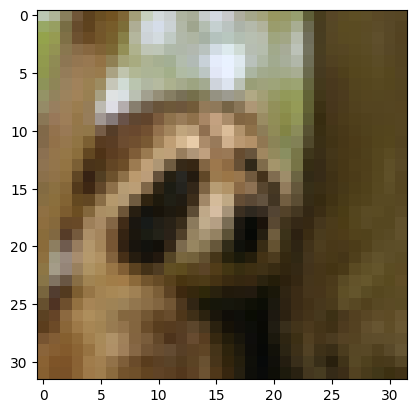

In [8]:
index = random.randint(0, 50000)
print("index =", index)
show_example(data_images[index], data_labels[index])

index = 1237
Label : 23


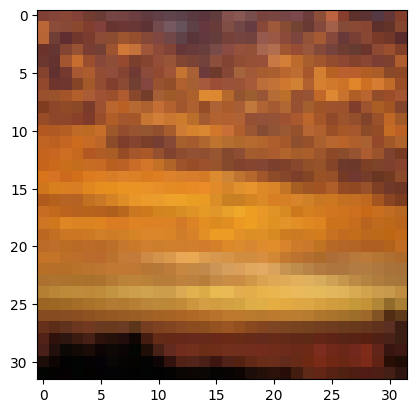

In [10]:
index = random.randint(0, 10000)
print("index =", index)
show_example(test_images[index], test_labels[index])

# Loading The Datset For Training Model

In [9]:
train_examples = 45000
validation_examples = 5000

class CustomDataset(Dataset):
    def __init__(self, images, labels):
        self.X = images
        self.Y = labels

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        return (self.X[index], self.Y[index])


dataset = CustomDataset(data_images, data_labels)
train_set, validation_set = random_split(dataset, [train_examples, validation_examples])
test_set = CustomDataset(test_images, test_labels)

# Defining The Model

In [12]:
class Wide_ResNet(nn.Module):
    def __init__(self, width = 4, dropout = 0.33, num_classes=100):
        super().__init__()

        self.block0 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )

        self.block11 = nn.Sequential(
            nn.Conv2d(16, 16*width, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(16*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            nn.Conv2d(16*width, 16*width, kernel_size=3, padding=1, stride=1),
        )
        self.shortcut1 = nn.Conv2d(16, 16*width, kernel_size=1, stride=2)
        self.block12 = nn.Sequential(
            nn.BatchNorm2d(16*width),
            nn.ReLU(),
            nn.Conv2d(16*width, 16*width, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(16*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            nn.Conv2d(16*width, 16*width, kernel_size=3, padding=1, stride=1),
        )


        self.pre_block2 = nn.Sequential(
            nn.BatchNorm2d(16*width),
            nn.ReLU(),
        )
        self.block21 = nn.Sequential(
            nn.Conv2d(16*width, 32*width, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(32*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            nn.Conv2d(32*width, 32*width, kernel_size=3, padding=1, stride=1),
        )
        self.shortcut2 = nn.Conv2d(16*width, 32*width, kernel_size=1, stride=2)
        self.block22 = nn.Sequential(
            nn.BatchNorm2d(32*width),
            nn.ReLU(),
            nn.Conv2d(32*width, 32*width, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(32*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            nn.Conv2d(32*width, 32*width, kernel_size=3, padding=1, stride=1),
        )

        self.pre_block3 = nn.Sequential(
            nn.BatchNorm2d(32*width),
            nn.ReLU(),
        )
        self.block31 = nn.Sequential(
            nn.Conv2d(32*width, 64*width, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(64*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            nn.Conv2d(64*width, 64*width, kernel_size=3, padding=1, stride=1),
        )
        self.shortcut3 = nn.Conv2d(32*width, 64*width, kernel_size=1, stride=2)
        self.block32 = nn.Sequential(
            nn.BatchNorm2d(64*width),
            nn.ReLU(),
            nn.Conv2d(64*width, 64*width, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            nn.Conv2d(64*width, 64*width, kernel_size=3, padding=1, stride=1),
        )

        self.pool_block = nn.Sequential(
            nn.BatchNorm2d(64*width),
            nn.ReLU(),
            nn.AvgPool2d(4, 4), # Depending on Dataset this should change
        )

        self.fc = nn.Sequential(
            nn.Linear(64*width, 64*width),
            nn.ReLU(),
            nn.Dropout1d(dropout/2),
            nn.Linear(64*width, num_classes)
        )

    def forward(self, x):
        # x.shape = B x 3 x 32 x 32

        x = self.block0(x)
        # x.shape = B x 16 x 32 x 32

        x1 = self.block11(x)
        x2 = self.shortcut1(x)
        x3 = x1 + x2
        x4 = self.block12(x3)
        x = x3 + x4
        # x.shape = B x 16*width x 16 x 16

        x = self.pre_block2(x)
        x1 = self.block21(x)
        x2 = self.shortcut2(x)
        x3 = x1 + x2
        x4 = self.block22(x3)
        x = x3 + x4
        # x.shape = B x 32*width x 8 x 8

        x = self.pre_block3(x)
        x1 = self.block31(x)
        x2 = self.shortcut3(x)
        x3 = x1 + x2
        x4 = self.block32(x3)
        x = x3 + x4
        # x.shape = B x 64*width x 4 x 4

        x = self.pool_block(x)
        # x.shape = B x 64*width x 1 x 1

        x = torch.flatten(x, start_dim=1)
        # flatten all dimensions except batch (0th dim)
        # x.shape = B x 64*width

        x = self.fc(x)
        # x.shape = B x num_classes

        return x


# Helper Functions To Train And Test The Model

In [10]:
def validate(model, validation_loader, loss_fn):
  validation_loss = 0.0
  validation_correct = 0
  model.eval()
  with torch.no_grad(): 
    for j, (x_val, y_val) in enumerate(validation_loader):
      x_val = x_val.to(device)
      y_val = y_val.to(device)

      y_pred = model(x_val)
      loss = loss_fn(y_pred, y_val)

      predicted = torch.argmax(y_pred.data, dim=1)
      validation_correct += (predicted == y_val).sum().item()
      validation_loss += loss.item()

  return validation_loss, validation_correct

In [11]:
def test(model, test_loader):
  top1_correct = 0
  top5_correct = 0
  model.eval()
  with torch.no_grad(): 
    for j, (x_val, y_val) in enumerate(test_loader):
      x_val = x_val.to(device)
      y_val = y_val.to(device)

      y_pred = model(x_val)

      predicted = torch.argmax(y_pred.data, dim=1)
      top1_correct += (predicted == y_val).sum().item()

      val, ind = torch.topk(y_pred.data, 5, dim=1, largest=True, sorted=True)
      for i in range(5):
        top5_correct += (ind[ :, i] == y_val).sum().item()

  return top1_correct / 100, top5_correct / 100

In [12]:
def train(model, optimizer, scheduler, loss_fn, train_loader, validation_loader, test_loader, learning_rate, num_epochs):
  history = {'train_loss' : [], 'val_loss' : [], 'train_acc' : [], 'val_acc' : [], 'test_acc1' : [], 'test_acc5' : [], 'time' : []}
  optimizer = optimizer(model.parameters(), learning_rate, momentum=0.9, nesterov=True)
  scheduler = scheduler(optimizer, T_max=len(train_loader)*num_epochs)

  for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0.0
    train_correct = 0
    start = time.time()
    for i, (x_batch, y_batch) in enumerate(train_loader):
      x_batch = x_batch.to(device)
      y_batch = y_batch.to(device)
    
      y_pred = model(x_batch)
      loss = loss_fn(y_pred, y_batch)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      scheduler.step()

      predicted = torch.argmax(y_pred.data, dim=1)
      train_correct += (predicted == y_batch).sum().item()
      train_loss += loss.item()
    end = time.time()
      
    # Validation Step
    validation_loss, validation_correct = validate(model, validation_loader, loss_fn)

    print("Epoch", epoch+1, "-\tTraining Loss :", train_loss/train_examples, "\tValidation Loss :", validation_loss/validation_examples)
    history['train_loss'].append(train_loss / train_examples)
    history['val_loss'].append(validation_loss / validation_examples)
    history['train_acc'].append(100 * train_correct / train_examples)
    history['val_acc'].append(100 * validation_correct / validation_examples)
    history['time'].append(end - start)

    # Test Step every 5th epoch
    if (epoch % 5) == 4:
      top1, top5 = test(model, test_loader)
      history['test_acc1'].append(top1)
      history['test_acc5'].append(top5)

      print("Training Accuracy =", 100 * train_correct / train_examples,
            "\tValidation Accuracy =", 100 * validation_correct / validation_examples,
            "\tTest Accuracy Top1 =", top1, "\tTest Accuracy Top5 =", top5)

  return history

In [13]:
def plot_loss(train_loss, val_loss):
  pyplot.plot(train_loss, '-b')
  pyplot.plot(val_loss, '-r')
  pyplot.xlabel('epoch')
  pyplot.ylabel('loss')
  pyplot.legend(['Training', 'Validation'])
  pyplot.title('Loss vs. No. of epochs')

In [14]:
def plot_acc(train_acc, val_acc):
  pyplot.plot(train_acc, '-b')
  pyplot.plot(val_acc, '-r')
  pyplot.xlabel('epoch')
  pyplot.ylabel('acurracy')
  pyplot.legend(['Training', 'Validation'])
  pyplot.title('Acurracy vs. No. of epochs')

In [15]:
def plot_test(test_acc1, test_acc5):
  x = range(5, 201, 5)
  x = x[ : len(test_acc1)]
  pyplot.plot(x, test_acc1, '-b')
  pyplot.plot(x, test_acc5, '-r')
  pyplot.xlabel('epoch')
  pyplot.ylabel('accuracy')
  pyplot.legend(['Top1 Accuracy', 'Top5 Accuracy'])
  pyplot.title('Accuracy vs. No. of epochs')

# Training The Model

In [19]:
model1 = Wide_ResNet(width=8, dropout=0.5).to(device)
summary(model1, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]          18,560
       BatchNorm2d-5          [-1, 128, 16, 16]             256
              ReLU-6          [-1, 128, 16, 16]               0
         Dropout2d-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,584
            Conv2d-9          [-1, 128, 16, 16]           2,176
      BatchNorm2d-10          [-1, 128, 16, 16]             256
             ReLU-11          [-1, 128, 16, 16]               0
           Conv2d-12          [-1, 128, 16, 16]         147,584
      BatchNorm2d-13          [-1, 128, 16, 16]             256
             ReLU-14          [-1, 128,

In [20]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=256, shuffle=False)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False)

optimizer = torch.optim.SGD
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR
loss_fn = F.cross_entropy

history1 = train(model1, optimizer, scheduler, loss_fn, train_loader, validation_loader, test_loader, learning_rate=0.01, num_epochs=100)

/data/home1/shishirm/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
  1%|          | 1/100 [00:09<16:15,  9.85s/it]

Epoch 1 -	Training Loss : 0.03456027432547675 	Validation Loss : 0.016843303108215333


  2%|▏         | 2/100 [00:18<14:50,  9.09s/it]

Epoch 2 -	Training Loss : 0.031768147039413455 	Validation Loss : 0.014978043603897095


  3%|▎         | 3/100 [00:27<14:24,  8.91s/it]

Epoch 3 -	Training Loss : 0.030673151344723173 	Validation Loss : 0.015291814470291138


  4%|▍         | 4/100 [00:35<13:57,  8.72s/it]

Epoch 4 -	Training Loss : 0.029702393854988945 	Validation Loss : 0.013750119256973267
Epoch 5 -	Training Loss : 0.028726562166213988 	Validation Loss : 0.013379308080673218


  5%|▌         | 5/100 [00:44<14:08,  8.93s/it]

Training Accuracy = 13.786666666666667 	Validation Accuracy = 19.82 	Test Accuracy Top1 = 19.45 	Test Accuracy Top5 = 47.81


  6%|▌         | 6/100 [00:53<14:02,  8.97s/it]

Epoch 6 -	Training Loss : 0.027905552032258776 	Validation Loss : 0.013328553724288941


  7%|▋         | 7/100 [01:02<13:46,  8.89s/it]

Epoch 7 -	Training Loss : 0.027171179474724663 	Validation Loss : 0.012238099002838135


  8%|▊         | 8/100 [01:11<13:27,  8.77s/it]

Epoch 8 -	Training Loss : 0.026462882407506307 	Validation Loss : 0.011609349727630615


  9%|▉         | 9/100 [01:19<13:11,  8.69s/it]

Epoch 9 -	Training Loss : 0.025882777759763928 	Validation Loss : 0.011778426170349122
Epoch 10 -	Training Loss : 0.025373433054818047 	Validation Loss : 0.010940859222412109


 10%|█         | 10/100 [01:28<13:15,  8.84s/it]

Training Accuracy = 21.746666666666666 	Validation Accuracy = 32.28 	Test Accuracy Top1 = 32.33 	Test Accuracy Top5 = 63.57


 11%|█         | 11/100 [01:37<13:02,  8.79s/it]

Epoch 11 -	Training Loss : 0.024794838004642064 	Validation Loss : 0.010595381212234497


 12%|█▏        | 12/100 [01:46<12:50,  8.75s/it]

Epoch 12 -	Training Loss : 0.024246033154593574 	Validation Loss : 0.010429138422012329


 13%|█▎        | 13/100 [01:54<12:41,  8.76s/it]

Epoch 13 -	Training Loss : 0.023756717777252197 	Validation Loss : 0.010133676195144653


 14%|█▍        | 14/100 [02:03<12:31,  8.74s/it]

Epoch 14 -	Training Loss : 0.023214847305085926 	Validation Loss : 0.00978655400276184
Epoch 15 -	Training Loss : 0.022701960701412626 	Validation Loss : 0.009617375135421753


 15%|█▌        | 15/100 [02:12<12:27,  8.80s/it]

Training Accuracy = 28.788888888888888 	Validation Accuracy = 38.12 	Test Accuracy Top1 = 39.42 	Test Accuracy Top5 = 70.96


 16%|█▌        | 16/100 [02:21<12:16,  8.76s/it]

Epoch 16 -	Training Loss : 0.022352337058385213 	Validation Loss : 0.009159837818145751


 17%|█▋        | 17/100 [02:29<11:55,  8.62s/it]

Epoch 17 -	Training Loss : 0.021836526934305826 	Validation Loss : 0.009328337860107422


 18%|█▊        | 18/100 [02:38<12:01,  8.80s/it]

Epoch 18 -	Training Loss : 0.021520364353391858 	Validation Loss : 0.008748992681503295


 19%|█▉        | 19/100 [02:47<11:48,  8.75s/it]

Epoch 19 -	Training Loss : 0.021077437655131023 	Validation Loss : 0.008603920936584472
Epoch 20 -	Training Loss : 0.020708502091301813 	Validation Loss : 0.00833602728843689


 20%|██        | 20/100 [02:56<11:48,  8.86s/it]

Training Accuracy = 34.19777777777778 	Validation Accuracy = 44.94 	Test Accuracy Top1 = 46.63 	Test Accuracy Top5 = 77.03


 21%|██        | 21/100 [03:05<11:42,  8.89s/it]

Epoch 21 -	Training Loss : 0.020453801663716634 	Validation Loss : 0.00883179087638855


 22%|██▏       | 22/100 [03:14<11:36,  8.93s/it]

Epoch 22 -	Training Loss : 0.020083868243959215 	Validation Loss : 0.007992363905906677


 23%|██▎       | 23/100 [03:22<11:15,  8.77s/it]

Epoch 23 -	Training Loss : 0.019857636366950142 	Validation Loss : 0.00787659752368927


 24%|██▍       | 24/100 [03:31<11:00,  8.69s/it]

Epoch 24 -	Training Loss : 0.019534504911634658 	Validation Loss : 0.007972723960876464
Epoch 25 -	Training Loss : 0.019210455253389148 	Validation Loss : 0.00777129225730896


 25%|██▌       | 25/100 [03:40<11:05,  8.87s/it]

Training Accuracy = 38.87555555555556 	Validation Accuracy = 48.18 	Test Accuracy Top1 = 49.09 	Test Accuracy Top5 = 79.02


 26%|██▌       | 26/100 [03:49<10:46,  8.74s/it]

Epoch 26 -	Training Loss : 0.018954907083511354 	Validation Loss : 0.00764407913684845


 27%|██▋       | 27/100 [03:57<10:29,  8.62s/it]

Epoch 27 -	Training Loss : 0.018672629613346522 	Validation Loss : 0.007354940867424011


 28%|██▊       | 28/100 [04:06<10:23,  8.66s/it]

Epoch 28 -	Training Loss : 0.018414810143576727 	Validation Loss : 0.007293650555610657


 29%|██▉       | 29/100 [04:14<10:14,  8.65s/it]

Epoch 29 -	Training Loss : 0.018045377445220948 	Validation Loss : 0.007265148591995239
Epoch 30 -	Training Loss : 0.017772018716070388 	Validation Loss : 0.007316046118736267


 30%|███       | 30/100 [04:23<10:15,  8.79s/it]

Training Accuracy = 42.93333333333333 	Validation Accuracy = 50.52 	Test Accuracy Top1 = 50.88 	Test Accuracy Top5 = 80.55


 31%|███       | 31/100 [04:32<10:00,  8.70s/it]

Epoch 31 -	Training Loss : 0.017572801785998873 	Validation Loss : 0.007111450672149658


 32%|███▏      | 32/100 [04:41<09:49,  8.66s/it]

Epoch 32 -	Training Loss : 0.017285513835483126 	Validation Loss : 0.00706774570941925


 33%|███▎      | 33/100 [04:50<09:48,  8.78s/it]

Epoch 33 -	Training Loss : 0.017128212830755447 	Validation Loss : 0.007050422358512878


 34%|███▍      | 34/100 [04:58<09:35,  8.71s/it]

Epoch 34 -	Training Loss : 0.016867790383762783 	Validation Loss : 0.006999286437034607
Epoch 35 -	Training Loss : 0.016601596604453192 	Validation Loss : 0.0069075369834899905


 35%|███▌      | 35/100 [05:07<09:36,  8.87s/it]

Training Accuracy = 46.81333333333333 	Validation Accuracy = 51.86 	Test Accuracy Top1 = 53.09 	Test Accuracy Top5 = 82.28


 36%|███▌      | 36/100 [05:16<09:21,  8.77s/it]

Epoch 36 -	Training Loss : 0.016436502742767332 	Validation Loss : 0.0068064073324203495


 37%|███▋      | 37/100 [05:25<09:13,  8.78s/it]

Epoch 37 -	Training Loss : 0.016198189544677735 	Validation Loss : 0.006792901039123535


 38%|███▊      | 38/100 [05:34<09:12,  8.92s/it]

Epoch 38 -	Training Loss : 0.015966518619325427 	Validation Loss : 0.006701587724685669


 39%|███▉      | 39/100 [05:43<08:58,  8.83s/it]

Epoch 39 -	Training Loss : 0.015770443158679537 	Validation Loss : 0.006745765399932861
Epoch 40 -	Training Loss : 0.015491714734501309 	Validation Loss : 0.006728609585762024


 40%|████      | 40/100 [05:52<08:59,  8.98s/it]

Training Accuracy = 50.54222222222222 	Validation Accuracy = 53.24 	Test Accuracy Top1 = 54.67 	Test Accuracy Top5 = 82.74


 41%|████      | 41/100 [06:00<08:42,  8.86s/it]

Epoch 41 -	Training Loss : 0.015307951434453328 	Validation Loss : 0.006689900183677673


 42%|████▏     | 42/100 [06:09<08:30,  8.79s/it]

Epoch 42 -	Training Loss : 0.015080364031261869 	Validation Loss : 0.006656569337844849


 43%|████▎     | 43/100 [06:18<08:14,  8.67s/it]

Epoch 43 -	Training Loss : 0.014907479622628953 	Validation Loss : 0.006711200618743897


 44%|████▍     | 44/100 [06:26<08:06,  8.69s/it]

Epoch 44 -	Training Loss : 0.01480672366089291 	Validation Loss : 0.006574134373664856
Epoch 45 -	Training Loss : 0.014624280529552036 	Validation Loss : 0.006730440974235535


 45%|████▌     | 45/100 [06:35<08:04,  8.82s/it]

Training Accuracy = 53.50222222222222 	Validation Accuracy = 54.38 	Test Accuracy Top1 = 54.59 	Test Accuracy Top5 = 83.09


 46%|████▌     | 46/100 [06:44<07:53,  8.78s/it]

Epoch 46 -	Training Loss : 0.014333152850468954 	Validation Loss : 0.0066155237197875975


 47%|████▋     | 47/100 [06:53<07:45,  8.78s/it]

Epoch 47 -	Training Loss : 0.014115480581919353 	Validation Loss : 0.00655692024230957


 48%|████▊     | 48/100 [07:01<07:33,  8.73s/it]

Epoch 48 -	Training Loss : 0.013952296177546184 	Validation Loss : 0.006682338428497314


 49%|████▉     | 49/100 [07:10<07:26,  8.76s/it]

Epoch 49 -	Training Loss : 0.013631671545240615 	Validation Loss : 0.006541796875
Epoch 50 -	Training Loss : 0.013620239853858948 	Validation Loss : 0.006747602844238281


 50%|█████     | 50/100 [07:20<07:26,  8.94s/it]

Training Accuracy = 57.02 	Validation Accuracy = 54.1 	Test Accuracy Top1 = 55.23 	Test Accuracy Top5 = 82.73


 51%|█████     | 51/100 [07:28<07:13,  8.85s/it]

Epoch 51 -	Training Loss : 0.013382740060488382 	Validation Loss : 0.00664011390209198


 52%|█████▏    | 52/100 [07:37<07:05,  8.86s/it]

Epoch 52 -	Training Loss : 0.013216801993052165 	Validation Loss : 0.006582433414459229


 53%|█████▎    | 53/100 [07:45<06:49,  8.70s/it]

Epoch 53 -	Training Loss : 0.013029568706618415 	Validation Loss : 0.006617962312698364


 54%|█████▍    | 54/100 [07:55<06:45,  8.81s/it]

Epoch 54 -	Training Loss : 0.012832071704334683 	Validation Loss : 0.0068656452417373654
Epoch 55 -	Training Loss : 0.01282590721713172 	Validation Loss : 0.0066181787967681885


 55%|█████▌    | 55/100 [08:04<06:40,  8.90s/it]

Training Accuracy = 60.04888888888889 	Validation Accuracy = 54.96 	Test Accuracy Top1 = 56.67 	Test Accuracy Top5 = 83.98


 56%|█████▌    | 56/100 [08:12<06:30,  8.88s/it]

Epoch 56 -	Training Loss : 0.012627996296352811 	Validation Loss : 0.006619080829620361


 57%|█████▋    | 57/100 [08:21<06:23,  8.91s/it]

Epoch 57 -	Training Loss : 0.012366343381669786 	Validation Loss : 0.006765829586982727


 58%|█████▊    | 58/100 [08:30<06:09,  8.79s/it]

Epoch 58 -	Training Loss : 0.012411505664719475 	Validation Loss : 0.006675561547279358


 59%|█████▉    | 59/100 [08:39<06:05,  8.92s/it]

Epoch 59 -	Training Loss : 0.012272388376129997 	Validation Loss : 0.006690024137496948
Epoch 60 -	Training Loss : 0.012073325408829582 	Validation Loss : 0.006637555694580078


 60%|██████    | 60/100 [08:49<06:03,  9.08s/it]

Training Accuracy = 62.63111111111111 	Validation Accuracy = 55.36 	Test Accuracy Top1 = 56.66 	Test Accuracy Top5 = 84.2


 61%|██████    | 61/100 [08:57<05:49,  8.97s/it]

Epoch 61 -	Training Loss : 0.011858511307504442 	Validation Loss : 0.006807130146026612


 62%|██████▏   | 62/100 [09:06<05:41,  8.97s/it]

Epoch 62 -	Training Loss : 0.01175481776661343 	Validation Loss : 0.0071471138000488285


 63%|██████▎   | 63/100 [09:15<05:27,  8.86s/it]

Epoch 63 -	Training Loss : 0.011555386413468255 	Validation Loss : 0.00683349814414978


 64%|██████▍   | 64/100 [09:24<05:17,  8.81s/it]

Epoch 64 -	Training Loss : 0.011508827386962043 	Validation Loss : 0.006765287446975708
Epoch 65 -	Training Loss : 0.011417128205299377 	Validation Loss : 0.006852140855789185


 65%|██████▌   | 65/100 [09:33<05:14,  8.99s/it]

Training Accuracy = 65.53333333333333 	Validation Accuracy = 56.1 	Test Accuracy Top1 = 56.63 	Test Accuracy Top5 = 84.0


 66%|██████▌   | 66/100 [09:42<05:06,  9.01s/it]

Epoch 66 -	Training Loss : 0.011286525438891517 	Validation Loss : 0.006806664252281189


 67%|██████▋   | 67/100 [09:51<04:52,  8.87s/it]

Epoch 67 -	Training Loss : 0.011318898055288526 	Validation Loss : 0.006860155487060547


 68%|██████▊   | 68/100 [09:59<04:40,  8.78s/it]

Epoch 68 -	Training Loss : 0.011193823907110427 	Validation Loss : 0.0068181261301040645


 69%|██████▉   | 69/100 [10:08<04:28,  8.67s/it]

Epoch 69 -	Training Loss : 0.011066522714826795 	Validation Loss : 0.0069140089511871335
Epoch 70 -	Training Loss : 0.010999699354171753 	Validation Loss : 0.006921714663505554


 70%|███████   | 70/100 [10:17<04:28,  8.96s/it]

Training Accuracy = 67.11777777777777 	Validation Accuracy = 56.18 	Test Accuracy Top1 = 57.27 	Test Accuracy Top5 = 84.44


 71%|███████   | 71/100 [10:26<04:19,  8.93s/it]

Epoch 71 -	Training Loss : 0.010990646033816867 	Validation Loss : 0.00694697265625


 72%|███████▏  | 72/100 [10:35<04:07,  8.85s/it]

Epoch 72 -	Training Loss : 0.01095047257343928 	Validation Loss : 0.007055692911148072


 73%|███████▎  | 73/100 [10:44<04:00,  8.92s/it]

Epoch 73 -	Training Loss : 0.010769962424702115 	Validation Loss : 0.00697231092453003


 74%|███████▍  | 74/100 [10:53<03:53,  9.00s/it]

Epoch 74 -	Training Loss : 0.010754052163494957 	Validation Loss : 0.007076309680938721
Epoch 75 -	Training Loss : 0.010732313210434384 	Validation Loss : 0.007008878397941589


 75%|███████▌  | 75/100 [11:02<03:48,  9.13s/it]

Training Accuracy = 68.30888888888889 	Validation Accuracy = 56.44 	Test Accuracy Top1 = 57.18 	Test Accuracy Top5 = 84.08


 76%|███████▌  | 76/100 [11:11<03:36,  9.03s/it]

Epoch 76 -	Training Loss : 0.010640701194604238 	Validation Loss : 0.007011223936080933


 77%|███████▋  | 77/100 [11:20<03:26,  8.99s/it]

Epoch 77 -	Training Loss : 0.010508677821689181 	Validation Loss : 0.0070923103809356685


 78%|███████▊  | 78/100 [11:29<03:18,  9.02s/it]

Epoch 78 -	Training Loss : 0.010440916454792023 	Validation Loss : 0.007024187922477722


 79%|███████▉  | 79/100 [11:38<03:09,  9.05s/it]

Epoch 79 -	Training Loss : 0.010395395763715108 	Validation Loss : 0.007110256600379944
Epoch 80 -	Training Loss : 0.010424689531326295 	Validation Loss : 0.007054091715812683


 80%|████████  | 80/100 [11:48<03:04,  9.21s/it]

Training Accuracy = 69.65555555555555 	Validation Accuracy = 56.98 	Test Accuracy Top1 = 57.09 	Test Accuracy Top5 = 84.33


 81%|████████  | 81/100 [11:57<02:54,  9.19s/it]

Epoch 81 -	Training Loss : 0.010388616801632776 	Validation Loss : 0.00715004506111145


 82%|████████▏ | 82/100 [12:06<02:42,  9.02s/it]

Epoch 82 -	Training Loss : 0.010396252920892503 	Validation Loss : 0.007114406108856201


 83%|████████▎ | 83/100 [12:15<02:32,  8.98s/it]

Epoch 83 -	Training Loss : 0.010324592447280883 	Validation Loss : 0.007099474287033081


 84%|████████▍ | 84/100 [12:23<02:22,  8.90s/it]

Epoch 84 -	Training Loss : 0.01028247468471527 	Validation Loss : 0.007118395066261291
Epoch 85 -	Training Loss : 0.010339796078205109 	Validation Loss : 0.00711748628616333


 85%|████████▌ | 85/100 [12:33<02:16,  9.11s/it]

Training Accuracy = 70.14888888888889 	Validation Accuracy = 56.7 	Test Accuracy Top1 = 57.18 	Test Accuracy Top5 = 84.31


 86%|████████▌ | 86/100 [12:42<02:07,  9.12s/it]

Epoch 86 -	Training Loss : 0.01031855742401547 	Validation Loss : 0.007179777264595032


 87%|████████▋ | 87/100 [12:51<01:56,  8.97s/it]

Epoch 87 -	Training Loss : 0.010342022323608398 	Validation Loss : 0.007162713408470154


 88%|████████▊ | 88/100 [12:59<01:46,  8.89s/it]

Epoch 88 -	Training Loss : 0.01026816166109509 	Validation Loss : 0.007137753081321716


 89%|████████▉ | 89/100 [13:08<01:38,  8.93s/it]

Epoch 89 -	Training Loss : 0.01020047246085273 	Validation Loss : 0.007159797477722168
Epoch 90 -	Training Loss : 0.010265193671650357 	Validation Loss : 0.007157155013084411


 90%|█████████ | 90/100 [13:18<01:31,  9.12s/it]

Training Accuracy = 70.50666666666666 	Validation Accuracy = 56.54 	Test Accuracy Top1 = 57.19 	Test Accuracy Top5 = 84.37


 91%|█████████ | 91/100 [13:27<01:21,  9.04s/it]

Epoch 91 -	Training Loss : 0.010176353475782607 	Validation Loss : 0.007166603779792786


 92%|█████████▏| 92/100 [13:36<01:11,  8.97s/it]

Epoch 92 -	Training Loss : 0.01024870181745953 	Validation Loss : 0.007153845596313477


 93%|█████████▎| 93/100 [13:45<01:02,  8.99s/it]

Epoch 93 -	Training Loss : 0.010173873303996193 	Validation Loss : 0.007155154967308045


 94%|█████████▍| 94/100 [13:54<00:53,  8.98s/it]

Epoch 94 -	Training Loss : 0.010264455087979634 	Validation Loss : 0.007156154346466065
Epoch 95 -	Training Loss : 0.010214797192149691 	Validation Loss : 0.007132556223869324


 95%|█████████▌| 95/100 [14:03<00:45,  9.15s/it]

Training Accuracy = 70.67555555555556 	Validation Accuracy = 56.62 	Test Accuracy Top1 = 57.36 	Test Accuracy Top5 = 84.27


 96%|█████████▌| 96/100 [14:12<00:35,  9.00s/it]

Epoch 96 -	Training Loss : 0.010219530194335514 	Validation Loss : 0.007152039861679077


 97%|█████████▋| 97/100 [14:20<00:26,  8.86s/it]

Epoch 97 -	Training Loss : 0.01030799469947815 	Validation Loss : 0.007156276106834412


 98%|█████████▊| 98/100 [14:29<00:17,  8.92s/it]

Epoch 98 -	Training Loss : 0.01027849151690801 	Validation Loss : 0.007168533110618591


 99%|█████████▉| 99/100 [14:38<00:08,  8.95s/it]

Epoch 99 -	Training Loss : 0.010167611988385518 	Validation Loss : 0.007130177879333496
Epoch 100 -	Training Loss : 0.010064826042122312 	Validation Loss : 0.007164909768104554


100%|██████████| 100/100 [14:48<00:00,  8.88s/it]

Training Accuracy = 71.12 	Validation Accuracy = 56.66 	Test Accuracy Top1 = 57.11 	Test Accuracy Top5 = 84.33


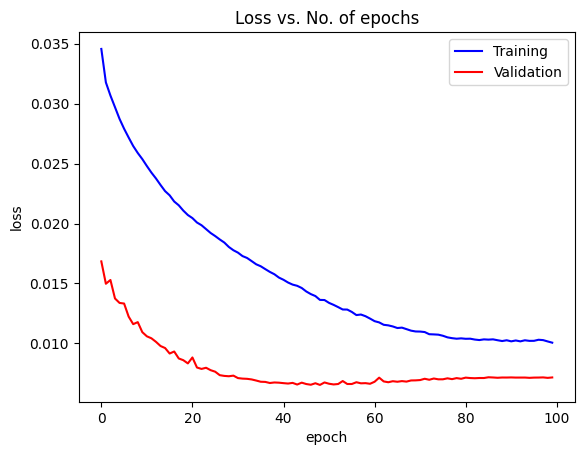

In [21]:
plot_loss(history1['train_loss'], history1['val_loss'])

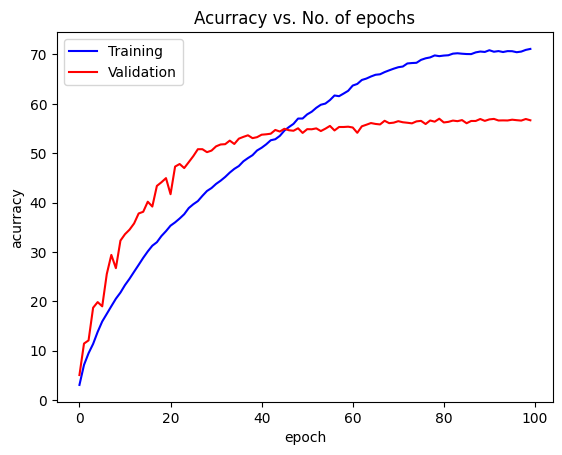

In [22]:
plot_acc(history1['train_acc'], history1['val_acc'])

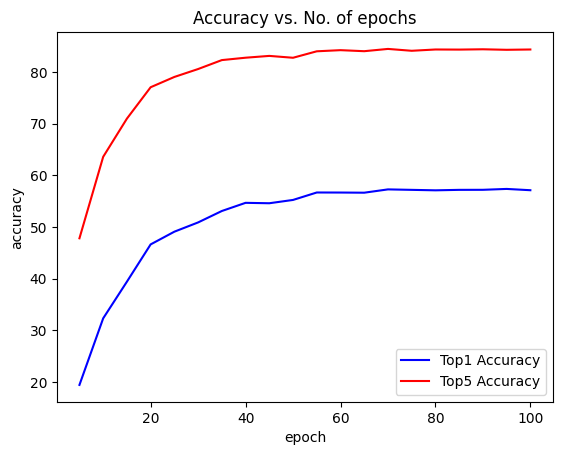

In [23]:
plot_test(history1['test_acc1'], history1['test_acc5'])

In [24]:
time_taken1 = np.array(history1['time'])
print("Average time per epoch for Wide_ResNet =", np.mean(time_taken1))

Average time per epoch for Wide_ResNet = 8.422302322387695


In [25]:
with open('wide_resnet_history_cifar', 'wb') as f:
  pickle.dump(history1, f)

# Defining The Model

In [16]:
from AA_CNN import AttentionConv2d

In [27]:
class Wide_AAResNet(nn.Module):
    def __init__(self, width = 4, dropout = 0.33, num_classes=100):
        super().__init__()
        self.Nh = 1
        self.dv = 8

        self.block0 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )

        self.block11 = nn.Sequential(
            nn.Conv2d(16, 16*width, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(16*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            # nn.Conv2d(16*width, 16*width, kernel_size=3, padding=1, stride=1),
            AttentionConv2d(
                input_dim = 16*width,
                output_dim = 16*width,
                dk = 4*self.dv*width,
                dv = self.dv*width,
                num_heads = self.Nh,
                kernel_size = 3,
                padding = 1,
                device=device,
                height=16,
                width=16,
            ),
        )
        self.shortcut1 = nn.Conv2d(16, 16*width, kernel_size=1, stride=2)
        self.block12 = nn.Sequential(
            nn.BatchNorm2d(16*width),
            nn.ReLU(),
            nn.Conv2d(16*width, 16*width, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(16*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            # nn.Conv2d(16*width, 16*width, kernel_size=3, padding=1, stride=1),
            AttentionConv2d(
                input_dim = 16*width,
                output_dim = 16*width,
                dk = 4*self.dv*width,
                dv = self.dv*width,
                num_heads = self.Nh,
                kernel_size = 3,
                padding = 1,
                device=device,
                height=16,
                width=16,
            ),
        )


        self.pre_block2 = nn.Sequential(
            nn.BatchNorm2d(16*width),
            nn.ReLU(),
        )
        self.block21 = nn.Sequential(
            nn.Conv2d(16*width, 32*width, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(32*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            # nn.Conv2d(32*width, 32*width, kernel_size=3, padding=1, stride=1),
            AttentionConv2d(
                input_dim = 32*width,
                output_dim = 32*width,
                dk = 8*self.dv*width,
                dv = 2*self.dv*width,
                num_heads = 2*self.Nh,
                kernel_size = 3,
                padding = 1,
                device=device,
                height=8,
                width=8,
            ),
        )
        self.shortcut2 = nn.Conv2d(16*width, 32*width, kernel_size=1, stride=2)
        self.block22 = nn.Sequential(
            nn.BatchNorm2d(32*width),
            nn.ReLU(),
            nn.Conv2d(32*width, 32*width, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(32*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            # nn.Conv2d(32*width, 32*width, kernel_size=3, padding=1, stride=1),
            AttentionConv2d(
                input_dim = 32*width,
                output_dim = 32*width,
                dk = 8*self.dv*width,
                dv = 2*self.dv*width,
                num_heads = 2*self.Nh,
                kernel_size = 3,
                padding = 1,
                device=device,
                height=8,
                width=8,
            ),
        )

        self.pre_block3 = nn.Sequential(
            nn.BatchNorm2d(32*width),
            nn.ReLU(),
        )
        self.block31 = nn.Sequential(
            nn.Conv2d(32*width, 64*width, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(64*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            # nn.Conv2d(64*width, 64*width, kernel_size=3, padding=1, stride=1),
            AttentionConv2d(
                input_dim = 64*width,
                output_dim = 64*width,
                dk = 16*self.dv*width,
                dv = 4*self.dv*width,
                num_heads = 4*self.Nh,
                kernel_size = 3,
                padding = 1,
                device=device,
                height=4,
                width=4,
            ),
        )
        self.shortcut3 = nn.Conv2d(32*width, 64*width, kernel_size=1, stride=2)
        self.block32 = nn.Sequential(
            nn.BatchNorm2d(64*width),
            nn.ReLU(),
            nn.Conv2d(64*width, 64*width, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            # nn.Conv2d(64*width, 64*width, kernel_size=3, padding=1, stride=1),
            AttentionConv2d(
                input_dim = 64*width,
                output_dim = 64*width,
                dk = 16*self.dv*width,
                dv = 4*self.dv*width,
                num_heads = 4*self.Nh,
                kernel_size = 3,
                padding = 1,
                device=device,
                height=4,
                width=4,
            ),
        )

        self.pool_block = nn.Sequential(
            nn.BatchNorm2d(64*width),
            nn.ReLU(),
            nn.AvgPool2d(4, 4),
        )

        self.fc = nn.Sequential(
            nn.Linear(64*width, 64*width),
            nn.ReLU(),
            nn.Dropout1d(dropout/2),
            nn.Linear(64*width, num_classes)
        )

    def forward(self, x):
        # x.shape = B x 3 x 32 x 32

        x = self.block0(x)
        # x.shape = B x 16 x 32 x 32

        x1 = self.block11(x)
        x2 = self.shortcut1(x)
        x3 = x1 + x2
        x4 = self.block12(x3)
        x = x4 + x3
        # x.shape = B x 16*width x 16 x 16

        x = self.pre_block2(x)
        x1 = self.block21(x)
        x2 = self.shortcut2(x)
        x3 = x1 + x2
        x4 = self.block22(x3)
        x = x4 + x3
        # x.shape = B x 32*width x 8 x 8

        x = self.pre_block3(x)
        x1 = self.block31(x)
        x2 = self.shortcut3(x)
        x3 = x1 + x2
        x4 = self.block32(x3)
        x = x4 + x3
        # x.shape = B x 64*width x 4 x 4

        x = self.pool_block(x)
        # x.shape = B x 64*width x 1 x 1

        x = torch.flatten(x, start_dim=1)
        # flatten all dimensions except batch (0th dim)
        # x.shape = B x 64*width

        x = self.fc(x)
        # x.shape = B x num_classes

        return x

# Training The Model

In [28]:
model2 = Wide_AAResNet(width=8, dropout=0.5).to(device)
summary(model2, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]          18,560
       BatchNorm2d-5          [-1, 128, 16, 16]             256
              ReLU-6          [-1, 128, 16, 16]               0
         Dropout2d-7          [-1, 128, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          73,792
            Conv2d-9          [-1, 576, 16, 16]          74,304
          Softmax-10          [-1, 1, 256, 256]               0
           Conv2d-11           [-1, 64, 16, 16]           4,160
  AttentionConv2d-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]           2,176
      BatchNorm2d-14          [-1, 128,

In [29]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=256, shuffle=False)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False)

optimizer = torch.optim.SGD
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR
loss_fn = F.cross_entropy

history2 = train(model2, optimizer, scheduler, loss_fn, train_loader, validation_loader, test_loader, learning_rate=0.01, num_epochs=100)

  1%|          | 1/100 [00:13<22:32, 13.66s/it]

Epoch 1 -	Training Loss : 0.034119411616855194 	Validation Loss : 0.01596509199142456


  2%|▏         | 2/100 [00:27<22:35, 13.83s/it]

Epoch 2 -	Training Loss : 0.031413429647021825 	Validation Loss : 0.01483521614074707


  3%|▎         | 3/100 [00:41<22:02, 13.63s/it]

Epoch 3 -	Training Loss : 0.030131653436024985 	Validation Loss : 0.014036386394500732


  4%|▍         | 4/100 [00:54<21:38, 13.53s/it]

Epoch 4 -	Training Loss : 0.028996963760587906 	Validation Loss : 0.013464451837539674
Epoch 5 -	Training Loss : 0.027746480406655206 	Validation Loss : 0.012881092023849487


  5%|▌         | 5/100 [01:08<21:58, 13.88s/it]

Training Accuracy = 15.984444444444444 	Validation Accuracy = 21.08 	Test Accuracy Top1 = 20.43 	Test Accuracy Top5 = 50.96


  6%|▌         | 6/100 [01:22<21:30, 13.73s/it]

Epoch 6 -	Training Loss : 0.026767486577563816 	Validation Loss : 0.012419906377792358


  7%|▋         | 7/100 [01:35<21:08, 13.64s/it]

Epoch 7 -	Training Loss : 0.025871860949198404 	Validation Loss : 0.011337383127212525


  8%|▊         | 8/100 [01:49<20:46, 13.55s/it]

Epoch 8 -	Training Loss : 0.02503532674577501 	Validation Loss : 0.011933043003082275


  9%|▉         | 9/100 [02:02<20:41, 13.64s/it]

Epoch 9 -	Training Loss : 0.0241999316851298 	Validation Loss : 0.010553390407562256
Epoch 10 -	Training Loss : 0.023487389352586534 	Validation Loss : 0.009874238491058349


 10%|█         | 10/100 [02:15<20:05, 13.40s/it]

Training Accuracy = 26.56 	Validation Accuracy = 37.62 	Test Accuracy Top1 = 38.16 	Test Accuracy Top5 = 69.64


 11%|█         | 11/100 [02:27<19:13, 12.97s/it]

Epoch 11 -	Training Loss : 0.022904929468366836 	Validation Loss : 0.009692813205718994


 12%|█▏        | 12/100 [02:39<18:38, 12.71s/it]

Epoch 12 -	Training Loss : 0.02237979006767273 	Validation Loss : 0.010284964084625245


 13%|█▎        | 13/100 [02:52<18:08, 12.52s/it]

Epoch 13 -	Training Loss : 0.021766937987009686 	Validation Loss : 0.009720045614242554


 14%|█▍        | 14/100 [03:04<17:46, 12.40s/it]

Epoch 14 -	Training Loss : 0.02130463096300761 	Validation Loss : 0.00917344651222229
Epoch 15 -	Training Loss : 0.020850713719262018 	Validation Loss : 0.008666823816299438


 15%|█▌        | 15/100 [03:17<17:49, 12.58s/it]

Training Accuracy = 33.80444444444444 	Validation Accuracy = 42.98 	Test Accuracy Top1 = 44.01 	Test Accuracy Top5 = 74.55


 16%|█▌        | 16/100 [03:29<17:33, 12.54s/it]

Epoch 16 -	Training Loss : 0.020458536100387573 	Validation Loss : 0.009216621828079224


 17%|█▋        | 17/100 [03:41<17:07, 12.38s/it]

Epoch 17 -	Training Loss : 0.019912030781639948 	Validation Loss : 0.00864438738822937


 18%|█▊        | 18/100 [03:53<16:46, 12.27s/it]

Epoch 18 -	Training Loss : 0.01946604675716824 	Validation Loss : 0.008099797415733337


 19%|█▉        | 19/100 [04:05<16:28, 12.21s/it]

Epoch 19 -	Training Loss : 0.019248365041944715 	Validation Loss : 0.008429917550086975
Epoch 20 -	Training Loss : 0.01884323108990987 	Validation Loss : 0.008042418718338013


 20%|██        | 20/100 [04:18<16:34, 12.43s/it]

Training Accuracy = 39.94444444444444 	Validation Accuracy = 45.82 	Test Accuracy Top1 = 47.34 	Test Accuracy Top5 = 77.09


 21%|██        | 21/100 [04:30<16:14, 12.33s/it]

Epoch 21 -	Training Loss : 0.018437138888570997 	Validation Loss : 0.00779002513885498


 22%|██▏       | 22/100 [04:42<15:55, 12.25s/it]

Epoch 22 -	Training Loss : 0.018117247727182175 	Validation Loss : 0.007759861755371094


 23%|██▎       | 23/100 [04:55<15:44, 12.27s/it]

Epoch 23 -	Training Loss : 0.017637652532259622 	Validation Loss : 0.00821735348701477


 24%|██▍       | 24/100 [05:07<15:30, 12.25s/it]

Epoch 24 -	Training Loss : 0.01744043640560574 	Validation Loss : 0.007718339586257935
Epoch 25 -	Training Loss : 0.01719746370845371 	Validation Loss : 0.0076773967266082765


 25%|██▌       | 25/100 [05:20<15:33, 12.44s/it]

Training Accuracy = 45.10888888888889 	Validation Accuracy = 47.3 	Test Accuracy Top1 = 49.39 	Test Accuracy Top5 = 78.44


 26%|██▌       | 26/100 [05:32<15:08, 12.28s/it]

Epoch 26 -	Training Loss : 0.016899466021855672 	Validation Loss : 0.007944403505325317


 27%|██▋       | 27/100 [05:45<15:18, 12.58s/it]

Epoch 27 -	Training Loss : 0.016543707972102695 	Validation Loss : 0.007546870756149292


 28%|██▊       | 28/100 [05:59<15:29, 12.92s/it]

Epoch 28 -	Training Loss : 0.016167452353901334 	Validation Loss : 0.007591304111480713


 29%|██▉       | 29/100 [06:13<15:39, 13.23s/it]

Epoch 29 -	Training Loss : 0.015918036047617594 	Validation Loss : 0.0077376994609832765
Epoch 30 -	Training Loss : 0.015787247819370694 	Validation Loss : 0.008377414393424988


 30%|███       | 30/100 [06:26<15:37, 13.39s/it]

Training Accuracy = 49.72888888888889 	Validation Accuracy = 44.92 	Test Accuracy Top1 = 45.8 	Test Accuracy Top5 = 74.84


 31%|███       | 31/100 [06:38<14:54, 12.97s/it]

Epoch 31 -	Training Loss : 0.01540238704416487 	Validation Loss : 0.007498058676719666


 32%|███▏      | 32/100 [06:51<14:36, 12.89s/it]

Epoch 32 -	Training Loss : 0.01506825921005673 	Validation Loss : 0.0074975518941879276


 33%|███▎      | 33/100 [07:03<14:09, 12.68s/it]

Epoch 33 -	Training Loss : 0.014786721356709798 	Validation Loss : 0.007454970455169678


 34%|███▍      | 34/100 [07:15<13:44, 12.50s/it]

Epoch 34 -	Training Loss : 0.014596891567442153 	Validation Loss : 0.007715656542778015
Epoch 35 -	Training Loss : 0.014222929210133023 	Validation Loss : 0.007534159159660339


 35%|███▌      | 35/100 [07:28<13:37, 12.58s/it]

Training Accuracy = 54.83111111111111 	Validation Accuracy = 49.38 	Test Accuracy Top1 = 50.76 	Test Accuracy Top5 = 79.31


 36%|███▌      | 36/100 [07:40<13:10, 12.36s/it]

Epoch 36 -	Training Loss : 0.01414690063794454 	Validation Loss : 0.0075502939701080326


 37%|███▋      | 37/100 [07:52<12:51, 12.24s/it]

Epoch 37 -	Training Loss : 0.013842072341177198 	Validation Loss : 0.007555494999885559


 38%|███▊      | 38/100 [08:04<12:32, 12.13s/it]

Epoch 38 -	Training Loss : 0.013592601405249701 	Validation Loss : 0.007474080443382263


 39%|███▉      | 39/100 [08:16<12:19, 12.13s/it]

Epoch 39 -	Training Loss : 0.013216120290756226 	Validation Loss : 0.0075116015434265136
Epoch 40 -	Training Loss : 0.013084920891125998 	Validation Loss : 0.007663685822486877


 40%|████      | 40/100 [08:29<12:24, 12.40s/it]

Training Accuracy = 58.78888888888889 	Validation Accuracy = 49.98 	Test Accuracy Top1 = 50.31 	Test Accuracy Top5 = 79.0


 41%|████      | 41/100 [08:41<12:05, 12.29s/it]

Epoch 41 -	Training Loss : 0.012935092266400655 	Validation Loss : 0.00804672064781189


 42%|████▏     | 42/100 [08:53<11:51, 12.27s/it]

Epoch 42 -	Training Loss : 0.012610265813933479 	Validation Loss : 0.00788001139163971


 43%|████▎     | 43/100 [09:05<11:36, 12.22s/it]

Epoch 43 -	Training Loss : 0.012435023437605964 	Validation Loss : 0.007783008885383606


 44%|████▍     | 44/100 [09:17<11:22, 12.19s/it]

Epoch 44 -	Training Loss : 0.012385491077105204 	Validation Loss : 0.007900927090644836
Epoch 45 -	Training Loss : 0.012110618122418721 	Validation Loss : 0.007862621569633485


 45%|████▌     | 45/100 [09:30<11:24, 12.44s/it]

Training Accuracy = 62.52 	Validation Accuracy = 50.46 	Test Accuracy Top1 = 51.32 	Test Accuracy Top5 = 79.53


 46%|████▌     | 46/100 [09:42<11:04, 12.31s/it]

Epoch 46 -	Training Loss : 0.011962203738424514 	Validation Loss : 0.007830609822273255


 47%|████▋     | 47/100 [09:54<10:48, 12.23s/it]

Epoch 47 -	Training Loss : 0.011731560941537222 	Validation Loss : 0.007820428109169006


 48%|████▊     | 48/100 [10:06<10:30, 12.13s/it]

Epoch 48 -	Training Loss : 0.01165516008536021 	Validation Loss : 0.008058957362174988


 49%|████▉     | 49/100 [10:18<10:15, 12.06s/it]

Epoch 49 -	Training Loss : 0.011368238647778828 	Validation Loss : 0.007943502449989318
Epoch 50 -	Training Loss : 0.011425919820202721 	Validation Loss : 0.00801267695426941


 50%|█████     | 50/100 [10:31<10:17, 12.36s/it]

Training Accuracy = 65.44222222222223 	Validation Accuracy = 51.3 	Test Accuracy Top1 = 52.0 	Test Accuracy Top5 = 79.7


 51%|█████     | 51/100 [10:43<09:59, 12.24s/it]

Epoch 51 -	Training Loss : 0.011182605640093485 	Validation Loss : 0.007986682367324829


 52%|█████▏    | 52/100 [10:55<09:45, 12.20s/it]

Epoch 52 -	Training Loss : 0.010919394931528303 	Validation Loss : 0.00807281289100647


 53%|█████▎    | 53/100 [11:08<09:34, 12.22s/it]

Epoch 53 -	Training Loss : 0.011020806399981181 	Validation Loss : 0.008142496657371521


 54%|█████▍    | 54/100 [11:20<09:20, 12.19s/it]

Epoch 54 -	Training Loss : 0.010793619354565938 	Validation Loss : 0.00813997163772583
Epoch 55 -	Training Loss : 0.010772732693619199 	Validation Loss : 0.008276422023773194


 55%|█████▌    | 55/100 [11:33<09:17, 12.39s/it]

Training Accuracy = 68.08 	Validation Accuracy = 51.02 	Test Accuracy Top1 = 50.99 	Test Accuracy Top5 = 78.97


 56%|█████▌    | 56/100 [11:45<09:03, 12.35s/it]

Epoch 56 -	Training Loss : 0.010568134203222062 	Validation Loss : 0.008292223572731018


 57%|█████▋    | 57/100 [11:57<08:50, 12.34s/it]

Epoch 57 -	Training Loss : 0.01060322047604455 	Validation Loss : 0.008288422226905822


 58%|█████▊    | 58/100 [12:09<08:34, 12.26s/it]

Epoch 58 -	Training Loss : 0.010449395590358311 	Validation Loss : 0.0085321280002594


 59%|█████▉    | 59/100 [12:21<08:19, 12.19s/it]

Epoch 59 -	Training Loss : 0.010430476501252917 	Validation Loss : 0.008366458654403686
Epoch 60 -	Training Loss : 0.01032881374359131 	Validation Loss : 0.008412319207191467


 60%|██████    | 60/100 [12:34<08:16, 12.42s/it]

Training Accuracy = 69.88222222222223 	Validation Accuracy = 51.16 	Test Accuracy Top1 = 51.97 	Test Accuracy Top5 = 79.95


 61%|██████    | 61/100 [12:47<08:02, 12.38s/it]

Epoch 61 -	Training Loss : 0.010264542746543884 	Validation Loss : 0.008380578899383545


 62%|██████▏   | 62/100 [12:59<07:49, 12.37s/it]

Epoch 62 -	Training Loss : 0.010206684361563788 	Validation Loss : 0.008379369950294495


 63%|██████▎   | 63/100 [13:11<07:34, 12.28s/it]

Epoch 63 -	Training Loss : 0.010114420134491391 	Validation Loss : 0.008322041487693787


 64%|██████▍   | 64/100 [13:23<07:22, 12.29s/it]

Epoch 64 -	Training Loss : 0.010078033090962304 	Validation Loss : 0.008421650552749634
Epoch 65 -	Training Loss : 0.010072612154483795 	Validation Loss : 0.008490532875061034


 65%|██████▌   | 65/100 [13:37<07:20, 12.60s/it]

Training Accuracy = 71.02 	Validation Accuracy = 52.06 	Test Accuracy Top1 = 52.46 	Test Accuracy Top5 = 80.12


 66%|██████▌   | 66/100 [13:49<07:02, 12.44s/it]

Epoch 66 -	Training Loss : 0.009952064316802555 	Validation Loss : 0.008619800925254821


 67%|██████▋   | 67/100 [14:01<06:50, 12.45s/it]

Epoch 67 -	Training Loss : 0.0098369745598899 	Validation Loss : 0.008546121764183045


 68%|██████▊   | 68/100 [14:13<06:35, 12.35s/it]

Epoch 68 -	Training Loss : 0.009979677081108093 	Validation Loss : 0.008674412989616393


 69%|██████▉   | 69/100 [14:25<06:18, 12.22s/it]

Epoch 69 -	Training Loss : 0.00991483432981703 	Validation Loss : 0.00864000072479248
Epoch 70 -	Training Loss : 0.009704509472846986 	Validation Loss : 0.00865172381401062


 70%|███████   | 70/100 [14:38<06:13, 12.46s/it]

Training Accuracy = 72.26222222222222 	Validation Accuracy = 52.34 	Test Accuracy Top1 = 52.45 	Test Accuracy Top5 = 80.34


 71%|███████   | 71/100 [14:50<05:59, 12.39s/it]

Epoch 71 -	Training Loss : 0.009716198523839314 	Validation Loss : 0.008675720858573913


 72%|███████▏  | 72/100 [15:03<05:45, 12.35s/it]

Epoch 72 -	Training Loss : 0.009576991147465175 	Validation Loss : 0.008706872177124023


 73%|███████▎  | 73/100 [15:15<05:33, 12.34s/it]

Epoch 73 -	Training Loss : 0.009743825931019252 	Validation Loss : 0.008662877488136291


 74%|███████▍  | 74/100 [15:27<05:21, 12.35s/it]

Epoch 74 -	Training Loss : 0.009632003017266591 	Validation Loss : 0.008781620764732361
Epoch 75 -	Training Loss : 0.009826136373149025 	Validation Loss : 0.008747333884239197


 75%|███████▌  | 75/100 [15:41<05:14, 12.60s/it]

Training Accuracy = 72.36222222222223 	Validation Accuracy = 52.66 	Test Accuracy Top1 = 52.76 	Test Accuracy Top5 = 80.36


 76%|███████▌  | 76/100 [15:53<04:59, 12.49s/it]

Epoch 76 -	Training Loss : 0.009675430835617914 	Validation Loss : 0.008794726300239563


 77%|███████▋  | 77/100 [16:05<04:45, 12.43s/it]

Epoch 77 -	Training Loss : 0.009688891242610083 	Validation Loss : 0.008776379656791688


 78%|███████▊  | 78/100 [16:17<04:30, 12.28s/it]

Epoch 78 -	Training Loss : 0.009601164854897393 	Validation Loss : 0.008764175748825074


 79%|███████▉  | 79/100 [16:29<04:16, 12.20s/it]

Epoch 79 -	Training Loss : 0.009524462617768181 	Validation Loss : 0.00874578320980072
Epoch 80 -	Training Loss : 0.00958139382733239 	Validation Loss : 0.008797782254219054


 80%|████████  | 80/100 [16:42<04:07, 12.38s/it]

Training Accuracy = 72.96 	Validation Accuracy = 52.56 	Test Accuracy Top1 = 52.89 	Test Accuracy Top5 = 80.44


 81%|████████  | 81/100 [16:54<03:54, 12.35s/it]

Epoch 81 -	Training Loss : 0.009462063309881422 	Validation Loss : 0.008807540678977967


 82%|████████▏ | 82/100 [17:06<03:40, 12.27s/it]

Epoch 82 -	Training Loss : 0.009526140171951717 	Validation Loss : 0.008789519047737122


 83%|████████▎ | 83/100 [17:18<03:27, 12.20s/it]

Epoch 83 -	Training Loss : 0.0095236633585559 	Validation Loss : 0.008803261351585389


 84%|████████▍ | 84/100 [17:30<03:14, 12.17s/it]

Epoch 84 -	Training Loss : 0.009499679776032766 	Validation Loss : 0.008788500332832336
Epoch 85 -	Training Loss : 0.009549085827668507 	Validation Loss : 0.00881353747844696


 85%|████████▌ | 85/100 [17:43<03:05, 12.34s/it]

Training Accuracy = 73.26222222222222 	Validation Accuracy = 52.26 	Test Accuracy Top1 = 53.13 	Test Accuracy Top5 = 80.37


 86%|████████▌ | 86/100 [17:55<02:51, 12.27s/it]

Epoch 86 -	Training Loss : 0.009505152878496383 	Validation Loss : 0.008832858014106751


 87%|████████▋ | 87/100 [18:07<02:38, 12.22s/it]

Epoch 87 -	Training Loss : 0.009464507577154372 	Validation Loss : 0.008834703898429871


 88%|████████▊ | 88/100 [18:19<02:25, 12.16s/it]

Epoch 88 -	Training Loss : 0.009520669498708513 	Validation Loss : 0.008821868324279785


 89%|████████▉ | 89/100 [18:31<02:12, 12.09s/it]

Epoch 89 -	Training Loss : 0.009470026761955685 	Validation Loss : 0.008825468945503234
Epoch 90 -	Training Loss : 0.009528687054581113 	Validation Loss : 0.008839769840240479


 90%|█████████ | 90/100 [18:44<02:03, 12.31s/it]

Training Accuracy = 73.41333333333333 	Validation Accuracy = 52.62 	Test Accuracy Top1 = 53.0 	Test Accuracy Top5 = 80.42


 91%|█████████ | 91/100 [18:56<01:49, 12.21s/it]

Epoch 91 -	Training Loss : 0.009477959944142236 	Validation Loss : 0.008825215458869934


 92%|█████████▏| 92/100 [19:08<01:36, 12.12s/it]

Epoch 92 -	Training Loss : 0.009319398784637452 	Validation Loss : 0.008850866508483888


 93%|█████████▎| 93/100 [19:20<01:24, 12.07s/it]

Epoch 93 -	Training Loss : 0.009387124700016446 	Validation Loss : 0.008870465517044067


 94%|█████████▍| 94/100 [19:32<01:12, 12.04s/it]

Epoch 94 -	Training Loss : 0.00946228005223804 	Validation Loss : 0.00883847689628601
Epoch 95 -	Training Loss : 0.00961967994901869 	Validation Loss : 0.008825715613365172


 95%|█████████▌| 95/100 [19:45<01:01, 12.29s/it]

Training Accuracy = 73.2088888888889 	Validation Accuracy = 52.38 	Test Accuracy Top1 = 52.9 	Test Accuracy Top5 = 80.39


 96%|█████████▌| 96/100 [19:57<00:48, 12.15s/it]

Epoch 96 -	Training Loss : 0.0094640750752555 	Validation Loss : 0.008825663590431214


 97%|█████████▋| 97/100 [20:08<00:36, 12.09s/it]

Epoch 97 -	Training Loss : 0.009555080046918657 	Validation Loss : 0.008842804336547851


 98%|█████████▊| 98/100 [20:21<00:24, 12.08s/it]

Epoch 98 -	Training Loss : 0.009469076095687019 	Validation Loss : 0.008836940217018127


 99%|█████████▉| 99/100 [20:33<00:12, 12.09s/it]

Epoch 99 -	Training Loss : 0.009396059079964955 	Validation Loss : 0.008887019085884094
Epoch 100 -	Training Loss : 0.009376636413733165 	Validation Loss : 0.008808109951019287


100%|██████████| 100/100 [20:46<00:00, 12.46s/it]

Training Accuracy = 73.82 	Validation Accuracy = 52.4 	Test Accuracy Top1 = 52.91 	Test Accuracy Top5 = 80.31


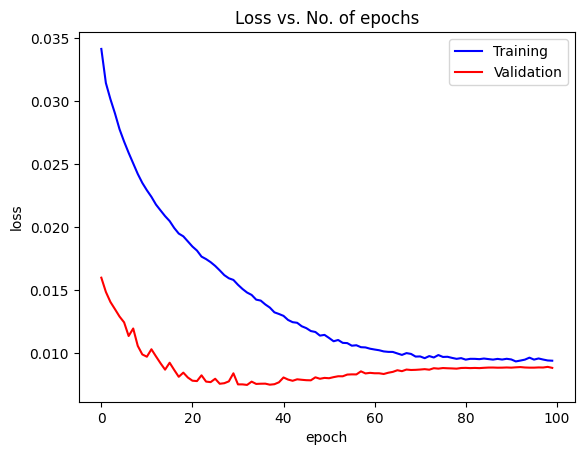

In [30]:
plot_loss(history2['train_loss'], history2['val_loss'])

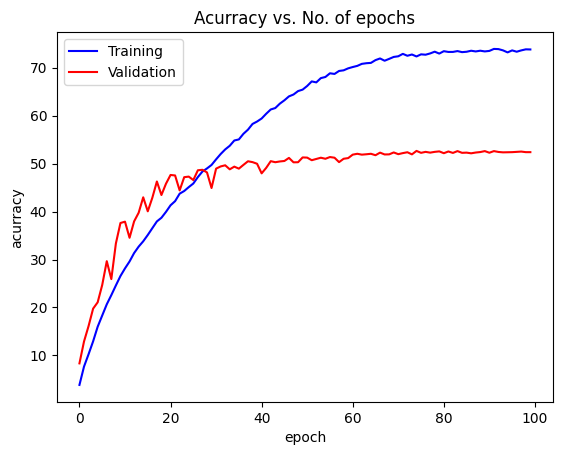

In [31]:
plot_acc(history2['train_acc'], history2['val_acc'])

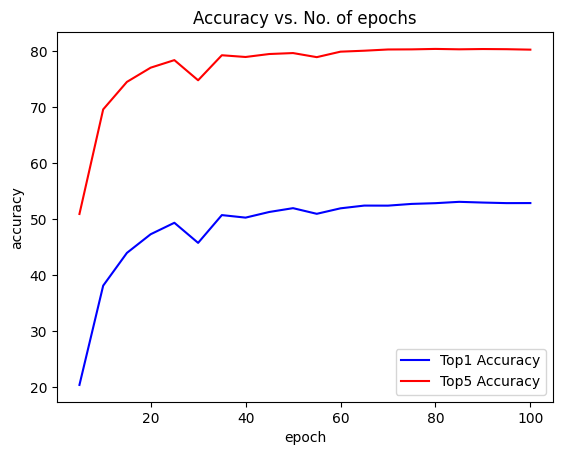

In [32]:
plot_test(history2['test_acc1'], history2['test_acc5'])

In [33]:
time_taken2 = np.array(history2['time'])
print("Average time per epoch for Wide_AAResNet =", np.mean(time_taken2))

Average time per epoch for Wide_AAResNet = 11.84288327217102


In [34]:
with open('wide_aaresnet_history_cifar', 'wb') as f:
  pickle.dump(history2, f)

# Defining The Model

In [17]:
from AA_CNN import LinearAttentionConv2d

In [36]:
class Wide_LAAResNet(nn.Module):
    def __init__(self, width = 4, dropout = 0.33, num_classes=100):
        super().__init__()
        self.Nh = 1
        self.dv = 8

        self.block0 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )

        self.block11 = nn.Sequential(
            nn.Conv2d(16, 16*width, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(16*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            # nn.Conv2d(16*width, 16*width, kernel_size=3, padding=1, stride=1),
            LinearAttentionConv2d(
                input_dim = 16*width,
                output_dim = 16*width,
                dk = 4*self.dv*width,
                dv = self.dv*width,
                num_heads = self.Nh,
                kernel_size = 3,
                padding = 1,
                device=device,
                height=16,
                width=16,
            ),
        )
        self.shortcut1 = nn.Conv2d(16, 16*width, kernel_size=1, stride=2)
        self.block12 = nn.Sequential(
            nn.BatchNorm2d(16*width),
            nn.ReLU(),
            nn.Conv2d(16*width, 16*width, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(16*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            # nn.Conv2d(16*width, 16*width, kernel_size=3, padding=1, stride=1),
            LinearAttentionConv2d(
                input_dim = 16*width,
                output_dim = 16*width,
                dk = 4*self.dv*width,
                dv = self.dv*width,
                num_heads = self.Nh,
                kernel_size = 3,
                padding = 1,
                device=device,
                height=16,
                width=16,
            ),
        )


        self.pre_block2 = nn.Sequential(
            nn.BatchNorm2d(16*width),
            nn.ReLU(),
        )
        self.block21 = nn.Sequential(
            nn.Conv2d(16*width, 32*width, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(32*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            # nn.Conv2d(32*width, 32*width, kernel_size=3, padding=1, stride=1),
            LinearAttentionConv2d(
                input_dim = 32*width,
                output_dim = 32*width,
                dk = 8*self.dv*width,
                dv = 2*self.dv*width,
                num_heads = 2*self.Nh,
                kernel_size = 3,
                padding = 1,
                device=device,
                height=8,
                width=8,
            ),
        )
        self.shortcut2 = nn.Conv2d(16*width, 32*width, kernel_size=1, stride=2)
        self.block22 = nn.Sequential(
            nn.BatchNorm2d(32*width),
            nn.ReLU(),
            nn.Conv2d(32*width, 32*width, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(32*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            # nn.Conv2d(32*width, 32*width, kernel_size=3, padding=1, stride=1),
            LinearAttentionConv2d(
                input_dim = 32*width,
                output_dim = 32*width,
                dk = 8*self.dv*width,
                dv = 2*self.dv*width,
                num_heads = 2*self.Nh,
                kernel_size = 3,
                padding = 1,
                device=device,
                height=8,
                width=8,
            ),
        )

        self.pre_block3 = nn.Sequential(
            nn.BatchNorm2d(32*width),
            nn.ReLU(),
        )
        self.block31 = nn.Sequential(
            nn.Conv2d(32*width, 64*width, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(64*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            # nn.Conv2d(64*width, 64*width, kernel_size=3, padding=1, stride=1),
            LinearAttentionConv2d(
                input_dim = 64*width,
                output_dim = 64*width,
                dk = 16*self.dv*width,
                dv = 4*self.dv*width,
                num_heads = 4*self.Nh,
                kernel_size = 3,
                padding = 1,
                device=device,
                height=4,
                width=4,
            ),
        )
        self.shortcut3 = nn.Conv2d(32*width, 64*width, kernel_size=1, stride=2)
        self.block32 = nn.Sequential(
            nn.BatchNorm2d(64*width),
            nn.ReLU(),
            nn.Conv2d(64*width, 64*width, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64*width),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            # nn.Conv2d(64*width, 64*width, kernel_size=3, padding=1, stride=1),
            LinearAttentionConv2d(
                input_dim = 64*width,
                output_dim = 64*width,
                dk = 16*self.dv*width,
                dv = 4*self.dv*width,
                num_heads = 4*self.Nh,
                kernel_size = 3,
                padding = 1,
                device=device,
                height=4,
                width=4,
            ),
        )

        self.pool_block = nn.Sequential(
            nn.BatchNorm2d(64*width),
            nn.ReLU(),
            nn.AvgPool2d(4, 4),
        )

        self.fc = nn.Sequential(
            nn.Linear(64*width, 64*width),
            nn.ReLU(),
            nn.Dropout1d(dropout/2),
            nn.Linear(64*width, num_classes)
        )

    def forward(self, x):
        # x.shape = B x 3 x 32 x 32

        x = self.block0(x)
        # x.shape = B x 16 x 32 x 32

        x1 = self.block11(x)
        x2 = self.shortcut1(x)
        x3 = x1 + x2
        x4 = self.block12(x3)
        x = x4 + x3
        # x.shape = B x 16*width x 16 x 16

        x = self.pre_block2(x)
        x1 = self.block21(x)
        x2 = self.shortcut2(x)
        x3 = x1 + x2
        x4 = self.block22(x3)
        x = x4 + x3
        # x.shape = B x 32*width x 8 x 8

        x = self.pre_block3(x)
        x1 = self.block31(x)
        x2 = self.shortcut3(x)
        x3 = x1 + x2
        x4 = self.block32(x3)
        x = x4 + x3
        # x.shape = B x 64*width x 4 x 4

        x = self.pool_block(x)
        # x.shape = B x 64*width x 1 x 1

        x = torch.flatten(x, start_dim=1)
        # flatten all dimensions except batch (0th dim)
        # x.shape = B x 64*width

        x = self.fc(x)
        # x.shape = B x num_classes

        return x

# Training The Model

In [37]:
model3 = Wide_LAAResNet(width=8, dropout=0.5).to(device)
summary(model3, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4          [-1, 128, 16, 16]          18,560
       BatchNorm2d-5          [-1, 128, 16, 16]             256
              ReLU-6          [-1, 128, 16, 16]               0
         Dropout2d-7          [-1, 128, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          73,792
            Conv2d-9          [-1, 576, 16, 16]          74,304
          Softmax-10          [-1, 1, 256, 256]               0
          Softmax-11          [-1, 1, 256, 256]               0
           Conv2d-12           [-1, 64, 16, 16]           4,160
LinearAttentionConv2d-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 

In [38]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=256, shuffle=False)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False)

optimizer = torch.optim.SGD
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR
loss_fn = F.cross_entropy

history3 = train(model3, optimizer, scheduler, loss_fn, train_loader, validation_loader, test_loader, learning_rate=0.01, num_epochs=100)

  1%|          | 1/100 [00:13<21:50, 13.24s/it]

Epoch 1 -	Training Loss : 0.034111004251903956 	Validation Loss : 0.016217080640792848


  2%|▏         | 2/100 [00:26<21:32, 13.19s/it]

Epoch 2 -	Training Loss : 0.0314492063416375 	Validation Loss : 0.014855755710601807


  3%|▎         | 3/100 [00:39<21:20, 13.20s/it]

Epoch 3 -	Training Loss : 0.03028910936779446 	Validation Loss : 0.014164253664016723


  4%|▍         | 4/100 [00:52<21:04, 13.17s/it]

Epoch 4 -	Training Loss : 0.029250139866934883 	Validation Loss : 0.013380627059936524
Epoch 5 -	Training Loss : 0.0281834867477417 	Validation Loss : 0.012955262994766235


  5%|▌         | 5/100 [01:06<21:20, 13.48s/it]

Training Accuracy = 14.82 	Validation Accuracy = 22.52 	Test Accuracy Top1 = 21.78 	Test Accuracy Top5 = 50.5


  6%|▌         | 6/100 [01:19<20:50, 13.31s/it]

Epoch 6 -	Training Loss : 0.027176888751983642 	Validation Loss : 0.012373189163208008


  7%|▋         | 7/100 [01:32<20:32, 13.25s/it]

Epoch 7 -	Training Loss : 0.026452580706278483 	Validation Loss : 0.011710879468917846


  8%|▊         | 8/100 [01:45<20:14, 13.20s/it]

Epoch 8 -	Training Loss : 0.025852895402908325 	Validation Loss : 0.011227248907089234


  9%|▉         | 9/100 [01:59<19:59, 13.19s/it]

Epoch 9 -	Training Loss : 0.02527923002243042 	Validation Loss : 0.011049434995651246
Epoch 10 -	Training Loss : 0.02469685147073534 	Validation Loss : 0.010625069284439088


 10%|█         | 10/100 [02:13<20:15, 13.50s/it]

Training Accuracy = 23.357777777777777 	Validation Accuracy = 33.7 	Test Accuracy Top1 = 34.05 	Test Accuracy Top5 = 65.33


 11%|█         | 11/100 [02:26<19:53, 13.41s/it]

Epoch 11 -	Training Loss : 0.02419891462855869 	Validation Loss : 0.010375237560272216


 12%|█▏        | 12/100 [02:39<19:36, 13.37s/it]

Epoch 12 -	Training Loss : 0.023745747656292386 	Validation Loss : 0.010205409240722656


 13%|█▎        | 13/100 [02:53<19:20, 13.34s/it]

Epoch 13 -	Training Loss : 0.023150181690851847 	Validation Loss : 0.011433623790740966


 14%|█▍        | 14/100 [03:06<19:03, 13.30s/it]

Epoch 14 -	Training Loss : 0.02298093130853441 	Validation Loss : 0.009859398174285888
Epoch 15 -	Training Loss : 0.022419374826219345 	Validation Loss : 0.009715865659713744


 15%|█▌        | 15/100 [03:20<19:17, 13.62s/it]

Training Accuracy = 29.702222222222222 	Validation Accuracy = 37.86 	Test Accuracy Top1 = 38.17 	Test Accuracy Top5 = 70.28


 16%|█▌        | 16/100 [03:33<18:53, 13.49s/it]

Epoch 16 -	Training Loss : 0.02206423888736301 	Validation Loss : 0.009161404657363892


 17%|█▋        | 17/100 [03:47<18:32, 13.41s/it]

Epoch 17 -	Training Loss : 0.02161024317741394 	Validation Loss : 0.009461263132095337


 18%|█▊        | 18/100 [04:00<18:14, 13.34s/it]

Epoch 18 -	Training Loss : 0.021276512744691636 	Validation Loss : 0.0088471923828125


 19%|█▉        | 19/100 [04:13<18:00, 13.34s/it]

Epoch 19 -	Training Loss : 0.020842732916937935 	Validation Loss : 0.008934043455123901
Epoch 20 -	Training Loss : 0.020488942872153387 	Validation Loss : 0.00895977792739868


 20%|██        | 20/100 [04:27<18:04, 13.56s/it]

Training Accuracy = 35.21111111111111 	Validation Accuracy = 41.24 	Test Accuracy Top1 = 42.61 	Test Accuracy Top5 = 73.91


 21%|██        | 21/100 [04:40<17:44, 13.48s/it]

Epoch 21 -	Training Loss : 0.020178891817728677 	Validation Loss : 0.0085697988986969


 22%|██▏       | 22/100 [04:54<17:27, 13.43s/it]

Epoch 22 -	Training Loss : 0.01974970088005066 	Validation Loss : 0.009310834074020386


 23%|██▎       | 23/100 [05:07<17:09, 13.38s/it]

Epoch 23 -	Training Loss : 0.019567121532228258 	Validation Loss : 0.008511582207679749


 24%|██▍       | 24/100 [05:20<16:50, 13.30s/it]

Epoch 24 -	Training Loss : 0.01925582430627611 	Validation Loss : 0.00790510241985321
Epoch 25 -	Training Loss : 0.01892711574766371 	Validation Loss : 0.007713865065574646


 25%|██▌       | 25/100 [05:34<16:56, 13.56s/it]

Training Accuracy = 39.522222222222226 	Validation Accuracy = 48.7 	Test Accuracy Top1 = 48.71 	Test Accuracy Top5 = 79.41


 26%|██▌       | 26/100 [05:48<16:39, 13.51s/it]

Epoch 26 -	Training Loss : 0.01874718028439416 	Validation Loss : 0.007819474816322327


 27%|██▋       | 27/100 [06:01<16:21, 13.45s/it]

Epoch 27 -	Training Loss : 0.018372328154246012 	Validation Loss : 0.007707919430732727


 28%|██▊       | 28/100 [06:14<16:06, 13.42s/it]

Epoch 28 -	Training Loss : 0.018207528278562757 	Validation Loss : 0.007450449633598328


 29%|██▉       | 29/100 [06:28<15:49, 13.38s/it]

Epoch 29 -	Training Loss : 0.017827796244621278 	Validation Loss : 0.008811940193176269
Epoch 30 -	Training Loss : 0.017665476727485658 	Validation Loss : 0.007405941104888916


 30%|███       | 30/100 [06:42<15:52, 13.60s/it]

Training Accuracy = 43.437777777777775 	Validation Accuracy = 49.42 	Test Accuracy Top1 = 50.81 	Test Accuracy Top5 = 80.15


 31%|███       | 31/100 [06:55<15:28, 13.46s/it]

Epoch 31 -	Training Loss : 0.017419605006111994 	Validation Loss : 0.0073199581146240235


 32%|███▏      | 32/100 [07:08<15:10, 13.38s/it]

Epoch 32 -	Training Loss : 0.017259881954722934 	Validation Loss : 0.007451652359962463


 33%|███▎      | 33/100 [07:21<14:52, 13.32s/it]

Epoch 33 -	Training Loss : 0.016864570599132114 	Validation Loss : 0.007068624687194824


 34%|███▍      | 34/100 [07:35<14:38, 13.31s/it]

Epoch 34 -	Training Loss : 0.016733224754863316 	Validation Loss : 0.007181875658035278
Epoch 35 -	Training Loss : 0.016352381388346354 	Validation Loss : 0.007102592849731445


 35%|███▌      | 35/100 [07:49<14:43, 13.59s/it]

Training Accuracy = 47.66 	Validation Accuracy = 51.54 	Test Accuracy Top1 = 51.88 	Test Accuracy Top5 = 81.32


 36%|███▌      | 36/100 [08:02<14:22, 13.47s/it]

Epoch 36 -	Training Loss : 0.016175463019476997 	Validation Loss : 0.007109460353851319


 37%|███▋      | 37/100 [08:15<14:03, 13.40s/it]

Epoch 37 -	Training Loss : 0.015888541926278008 	Validation Loss : 0.007037487602233887


 38%|███▊      | 38/100 [08:29<13:49, 13.37s/it]

Epoch 38 -	Training Loss : 0.01571875261200799 	Validation Loss : 0.007178754806518555


 39%|███▉      | 39/100 [08:42<13:35, 13.37s/it]

Epoch 39 -	Training Loss : 0.015526040058665806 	Validation Loss : 0.0069321988582611085
Epoch 40 -	Training Loss : 0.01520199179649353 	Validation Loss : 0.006999027967453003


 40%|████      | 40/100 [08:56<13:37, 13.63s/it]

Training Accuracy = 51.184444444444445 	Validation Accuracy = 51.78 	Test Accuracy Top1 = 52.74 	Test Accuracy Top5 = 82.14


 41%|████      | 41/100 [09:09<13:17, 13.52s/it]

Epoch 41 -	Training Loss : 0.01501187813282013 	Validation Loss : 0.006988472056388855


 42%|████▏     | 42/100 [09:23<12:59, 13.44s/it]

Epoch 42 -	Training Loss : 0.014902978256013659 	Validation Loss : 0.006972578310966491


 43%|████▎     | 43/100 [09:36<12:38, 13.30s/it]

Epoch 43 -	Training Loss : 0.014713514465755886 	Validation Loss : 0.0073765385389328005


 44%|████▍     | 44/100 [09:49<12:25, 13.31s/it]

Epoch 44 -	Training Loss : 0.014441234707832337 	Validation Loss : 0.006999240756034851
Epoch 45 -	Training Loss : 0.014231185081270007 	Validation Loss : 0.008320610952377318


 45%|████▌     | 45/100 [10:03<12:27, 13.59s/it]

Training Accuracy = 54.88444444444445 	Validation Accuracy = 46.22 	Test Accuracy Top1 = 47.23 	Test Accuracy Top5 = 76.7


 46%|████▌     | 46/100 [10:16<12:08, 13.49s/it]

Epoch 46 -	Training Loss : 0.01409299307399326 	Validation Loss : 0.006909477210044861


 47%|████▋     | 47/100 [10:30<11:49, 13.39s/it]

Epoch 47 -	Training Loss : 0.013922323830922444 	Validation Loss : 0.0070499239444732666


 48%|████▊     | 48/100 [10:43<11:34, 13.36s/it]

Epoch 48 -	Training Loss : 0.013609950460327995 	Validation Loss : 0.006879323124885559


 49%|████▉     | 49/100 [10:56<11:22, 13.39s/it]

Epoch 49 -	Training Loss : 0.013498903200361463 	Validation Loss : 0.008386340951919556
Epoch 50 -	Training Loss : 0.01322064847946167 	Validation Loss : 0.006930053734779358


 50%|█████     | 50/100 [11:10<11:17, 13.56s/it]

Training Accuracy = 58.37555555555556 	Validation Accuracy = 52.78 	Test Accuracy Top1 = 54.25 	Test Accuracy Top5 = 82.85


 51%|█████     | 51/100 [11:23<10:55, 13.37s/it]

Epoch 51 -	Training Loss : 0.013162382099363538 	Validation Loss : 0.006951927495002746


 52%|█████▏    | 52/100 [11:36<10:35, 13.24s/it]

Epoch 52 -	Training Loss : 0.013070701514350044 	Validation Loss : 0.006941203594207764


 53%|█████▎    | 53/100 [11:49<10:16, 13.12s/it]

Epoch 53 -	Training Loss : 0.01277491164472368 	Validation Loss : 0.007001538109779358


 54%|█████▍    | 54/100 [12:02<10:01, 13.07s/it]

Epoch 54 -	Training Loss : 0.01267774526807997 	Validation Loss : 0.006907664012908935
Epoch 55 -	Training Loss : 0.012445479718844096 	Validation Loss : 0.006894225573539734


 55%|█████▌    | 55/100 [12:16<09:57, 13.28s/it]

Training Accuracy = 61.37111111111111 	Validation Accuracy = 53.78 	Test Accuracy Top1 = 54.56 	Test Accuracy Top5 = 82.97


 56%|█████▌    | 56/100 [12:29<09:39, 13.16s/it]

Epoch 56 -	Training Loss : 0.012297873944706387 	Validation Loss : 0.006993128514289856


 57%|█████▋    | 57/100 [12:41<09:22, 13.08s/it]

Epoch 57 -	Training Loss : 0.01235356800556183 	Validation Loss : 0.007049041509628296


 58%|█████▊    | 58/100 [12:54<09:07, 13.02s/it]

Epoch 58 -	Training Loss : 0.0120746667848693 	Validation Loss : 0.007167835259437561


 59%|█████▉    | 59/100 [13:07<08:52, 12.99s/it]

Epoch 59 -	Training Loss : 0.011931005350748697 	Validation Loss : 0.007166725301742553
Epoch 60 -	Training Loss : 0.011847187023692661 	Validation Loss : 0.007173425221443176


 60%|██████    | 60/100 [13:21<08:49, 13.24s/it]

Training Accuracy = 63.73777777777778 	Validation Accuracy = 53.5 	Test Accuracy Top1 = 54.39 	Test Accuracy Top5 = 82.69


 61%|██████    | 61/100 [13:34<08:31, 13.13s/it]

Epoch 61 -	Training Loss : 0.011695093862215677 	Validation Loss : 0.007025233006477356


 62%|██████▏   | 62/100 [13:47<08:16, 13.05s/it]

Epoch 62 -	Training Loss : 0.01163588191403283 	Validation Loss : 0.007155204129219055


 63%|██████▎   | 63/100 [14:00<08:01, 13.01s/it]

Epoch 63 -	Training Loss : 0.011444520972834693 	Validation Loss : 0.007130141496658325


 64%|██████▍   | 64/100 [14:13<07:49, 13.05s/it]

Epoch 64 -	Training Loss : 0.011366034826967452 	Validation Loss : 0.007271007800102234
Epoch 65 -	Training Loss : 0.011163232860300276 	Validation Loss : 0.007203975081443786


 65%|██████▌   | 65/100 [14:27<07:47, 13.35s/it]

Training Accuracy = 66.32222222222222 	Validation Accuracy = 54.24 	Test Accuracy Top1 = 54.82 	Test Accuracy Top5 = 82.57


 66%|██████▌   | 66/100 [14:40<07:28, 13.20s/it]

Epoch 66 -	Training Loss : 0.011162097826268938 	Validation Loss : 0.007197683548927307


 67%|██████▋   | 67/100 [14:53<07:11, 13.08s/it]

Epoch 67 -	Training Loss : 0.011014016012350717 	Validation Loss : 0.007212175297737122


 68%|██████▊   | 68/100 [15:05<06:56, 13.01s/it]

Epoch 68 -	Training Loss : 0.010992848983075884 	Validation Loss : 0.007267298150062561


 69%|██████▉   | 69/100 [15:18<06:41, 12.95s/it]

Epoch 69 -	Training Loss : 0.010841674770249261 	Validation Loss : 0.007361808466911316
Epoch 70 -	Training Loss : 0.010723962977197436 	Validation Loss : 0.007350821805000306


 70%|███████   | 70/100 [15:32<06:34, 13.16s/it]

Training Accuracy = 68.16 	Validation Accuracy = 54.18 	Test Accuracy Top1 = 54.71 	Test Accuracy Top5 = 82.64


 71%|███████   | 71/100 [15:45<06:17, 13.03s/it]

Epoch 71 -	Training Loss : 0.010773843563927545 	Validation Loss : 0.0073315144777297975


 72%|███████▏  | 72/100 [15:58<06:03, 12.98s/it]

Epoch 72 -	Training Loss : 0.010633809906906553 	Validation Loss : 0.007637463259696961


 73%|███████▎  | 73/100 [16:10<05:48, 12.90s/it]

Epoch 73 -	Training Loss : 0.010618254392676883 	Validation Loss : 0.00735921528339386


 74%|███████▍  | 74/100 [16:23<05:34, 12.87s/it]

Epoch 74 -	Training Loss : 0.010506185229619344 	Validation Loss : 0.007366307640075683
Epoch 75 -	Training Loss : 0.010701822805404663 	Validation Loss : 0.007458729791641235


 75%|███████▌  | 75/100 [16:37<05:28, 13.15s/it]

Training Accuracy = 68.7311111111111 	Validation Accuracy = 54.26 	Test Accuracy Top1 = 54.64 	Test Accuracy Top5 = 82.44


 76%|███████▌  | 76/100 [16:50<05:13, 13.06s/it]

Epoch 76 -	Training Loss : 0.010566382025347815 	Validation Loss : 0.007446646404266358


 77%|███████▋  | 77/100 [17:02<04:58, 12.98s/it]

Epoch 77 -	Training Loss : 0.010440773420863681 	Validation Loss : 0.007414135909080505


 78%|███████▊  | 78/100 [17:15<04:44, 12.94s/it]

Epoch 78 -	Training Loss : 0.010341264096895854 	Validation Loss : 0.007427688384056092


 79%|███████▉  | 79/100 [17:28<04:30, 12.90s/it]

Epoch 79 -	Training Loss : 0.0103042193836636 	Validation Loss : 0.007433327198028564
Epoch 80 -	Training Loss : 0.010346714025073582 	Validation Loss : 0.007493189787864685


 80%|████████  | 80/100 [17:42<04:24, 13.24s/it]

Training Accuracy = 70.0911111111111 	Validation Accuracy = 54.0 	Test Accuracy Top1 = 54.87 	Test Accuracy Top5 = 83.01


 81%|████████  | 81/100 [17:55<04:09, 13.14s/it]

Epoch 81 -	Training Loss : 0.010416268666585286 	Validation Loss : 0.007509195971488952


 82%|████████▏ | 82/100 [18:08<03:54, 13.05s/it]

Epoch 82 -	Training Loss : 0.010318099068270789 	Validation Loss : 0.007535606217384338


 83%|████████▎ | 83/100 [18:21<03:40, 12.97s/it]

Epoch 83 -	Training Loss : 0.010255528779824575 	Validation Loss : 0.007518382668495178


 84%|████████▍ | 84/100 [18:34<03:27, 12.95s/it]

Epoch 84 -	Training Loss : 0.010161614025963677 	Validation Loss : 0.007510072922706604
Epoch 85 -	Training Loss : 0.010249138797654047 	Validation Loss : 0.007563038516044617


 85%|████████▌ | 85/100 [18:48<03:18, 13.26s/it]

Training Accuracy = 70.52666666666667 	Validation Accuracy = 54.24 	Test Accuracy Top1 = 54.99 	Test Accuracy Top5 = 82.79


 86%|████████▌ | 86/100 [19:01<03:04, 13.20s/it]

Epoch 86 -	Training Loss : 0.010165712704923419 	Validation Loss : 0.0075380050659179685


 87%|████████▋ | 87/100 [19:14<02:51, 13.19s/it]

Epoch 87 -	Training Loss : 0.010129115666283502 	Validation Loss : 0.0075205978631973265


 88%|████████▊ | 88/100 [19:27<02:37, 13.14s/it]

Epoch 88 -	Training Loss : 0.01014977145459917 	Validation Loss : 0.0075507691144943235


 89%|████████▉ | 89/100 [19:40<02:23, 13.09s/it]

Epoch 89 -	Training Loss : 0.010245135672887167 	Validation Loss : 0.007543574619293213
Epoch 90 -	Training Loss : 0.01013099827501509 	Validation Loss : 0.007542495942115784


 90%|█████████ | 90/100 [19:54<02:13, 13.40s/it]

Training Accuracy = 70.94 	Validation Accuracy = 54.24 	Test Accuracy Top1 = 55.12 	Test Accuracy Top5 = 82.84


 91%|█████████ | 91/100 [20:07<01:59, 13.25s/it]

Epoch 91 -	Training Loss : 0.010080195926295386 	Validation Loss : 0.007543770241737365


 92%|█████████▏| 92/100 [20:20<01:46, 13.25s/it]

Epoch 92 -	Training Loss : 0.010126126935746934 	Validation Loss : 0.007555393290519715


 93%|█████████▎| 93/100 [20:33<01:32, 13.17s/it]

Epoch 93 -	Training Loss : 0.01008290189107259 	Validation Loss : 0.007543726181983948


 94%|█████████▍| 94/100 [20:46<01:18, 13.16s/it]

Epoch 94 -	Training Loss : 0.010126781780189938 	Validation Loss : 0.007569151949882507
Epoch 95 -	Training Loss : 0.009991200764973958 	Validation Loss : 0.007549461507797241


 95%|█████████▌| 95/100 [21:01<01:07, 13.54s/it]

Training Accuracy = 71.63111111111111 	Validation Accuracy = 54.46 	Test Accuracy Top1 = 55.41 	Test Accuracy Top5 = 83.01


 96%|█████████▌| 96/100 [21:14<00:53, 13.47s/it]

Epoch 96 -	Training Loss : 0.010059666971365611 	Validation Loss : 0.007551802468299866


 97%|█████████▋| 97/100 [21:27<00:40, 13.47s/it]

Epoch 97 -	Training Loss : 0.010088985448413424 	Validation Loss : 0.007534152317047119


 98%|█████████▊| 98/100 [21:41<00:26, 13.46s/it]

Epoch 98 -	Training Loss : 0.010187597419155968 	Validation Loss : 0.007547552323341369


 99%|█████████▉| 99/100 [21:54<00:13, 13.38s/it]

Epoch 99 -	Training Loss : 0.010189709436893462 	Validation Loss : 0.007560835599899292
Epoch 100 -	Training Loss : 0.010056406491332584 	Validation Loss : 0.007530298590660095


100%|██████████| 100/100 [22:08<00:00, 13.29s/it]

Training Accuracy = 71.30444444444444 	Validation Accuracy = 54.64 	Test Accuracy Top1 = 55.32 	Test Accuracy Top5 = 82.95


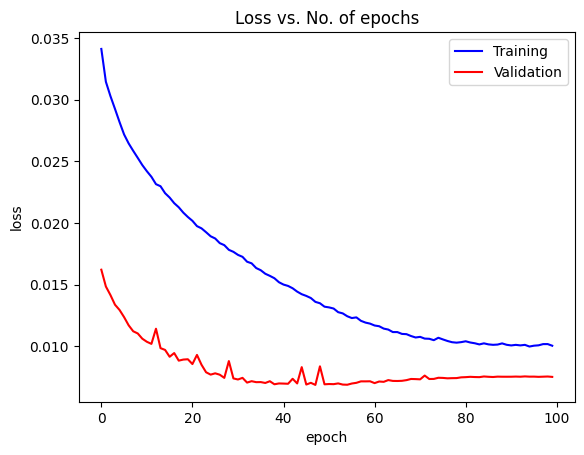

In [39]:
plot_loss(history3['train_loss'], history3['val_loss'])

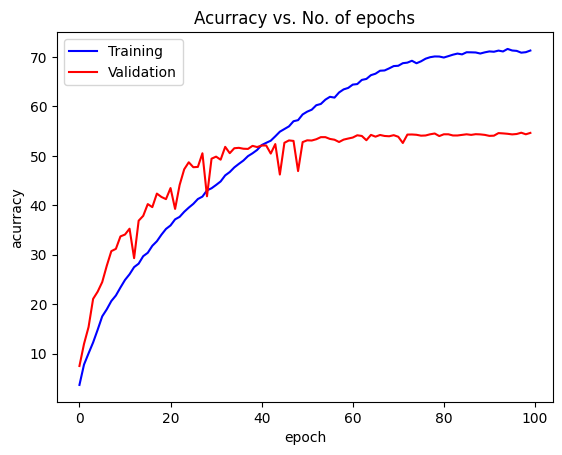

In [40]:
plot_acc(history3['train_acc'], history3['val_acc'])

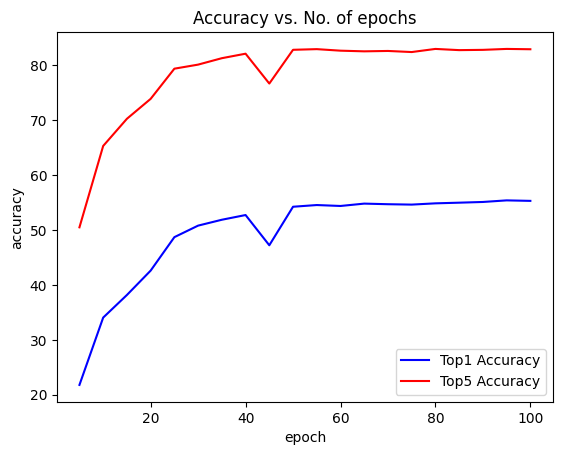

In [41]:
plot_test(history3['test_acc1'], history3['test_acc5'])

In [42]:
time_taken3 = np.array(history3['time'])
print("Average time per epoch for Wide_LAAResNet =", np.mean(time_taken3))

Average time per epoch for Wide_LAAResNet = 12.614249691963195


In [43]:
with open('wide_laaresnet_history_cifar', 'wb') as f:
  pickle.dump(history3, f)

# Training A Smaller Network To Test Our Hypothesis

Hypothesis - Above all 3 shows similar accuracy and this is because the CNN (only) model's field of view is covering the entire image.

The following model is designed such that the CNN model's field of view should not cover the entire image, this would help us to understand whether the Attention Augmented Conv layers are helping to capture the long range interactions.

In [23]:
class Simple_CNN(nn.Module):
    def __init__(self, dropout=0.33, num_classes=100):
        super().__init__()
        
        self.block0 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )

        self.block1 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        self.pool = nn.AvgPool2d(8, 8)

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        # x.shape = B x 3 X 32 x 32

        x = self.block0(x)
        # x.shape = B x 16 X 32 x 32

        x = self.block1(x)
        # x.shape = B x 64 X 16 x 16

        x = self.block2(x)
        # x.shape = B x 256 X 8 x 8

        x = self.pool(x)
        # x.shape = B x 256 X 1 x 1

        x = torch.flatten(x, start_dim=1)
        # x.shape = B x 256

        x = self.fc(x)
        # x.shape = B x num_classes

        return x

In [24]:
model4 = Simple_CNN(dropout=0.5).to(device)
summary(model4, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
       BatchNorm2d-5           [-1, 32, 16, 16]              64
              ReLU-6           [-1, 32, 16, 16]               0
         Dropout2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 64, 16, 16]          18,496
       BatchNorm2d-9           [-1, 64, 16, 16]             128
             ReLU-10           [-1, 64, 16, 16]               0
           Conv2d-11            [-1, 128, 8, 8]          73,856
      BatchNorm2d-12            [-1, 128, 8, 8]             256
             ReLU-13            [-1, 128, 8, 8]               0
        Dropout2d-14            [-1, 12

In [25]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=256, shuffle=False)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False)

optimizer = torch.optim.SGD
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR
loss_fn = F.cross_entropy

history4 = train(model4, optimizer, scheduler, loss_fn, train_loader, validation_loader, test_loader, learning_rate=0.01, num_epochs=100)

  1%|          | 1/100 [00:02<04:12,  2.55s/it]

Epoch 1 -	Training Loss : 0.03373274229897393 	Validation Loss : 0.016504830741882325


  2%|▏         | 2/100 [00:05<04:37,  2.83s/it]

Epoch 2 -	Training Loss : 0.03170069773991903 	Validation Loss : 0.016024356603622437


  3%|▎         | 3/100 [00:08<04:51,  3.00s/it]

Epoch 3 -	Training Loss : 0.030768627903196545 	Validation Loss : 0.01564553236961365


  4%|▍         | 4/100 [00:11<04:51,  3.04s/it]

Epoch 4 -	Training Loss : 0.030185377354092068 	Validation Loss : 0.015250194263458252
Epoch 5 -	Training Loss : 0.029689894209967718 	Validation Loss : 0.015108430099487305


  5%|▌         | 5/100 [00:14<04:44,  2.99s/it]

Training Accuracy = 10.591111111111111 	Validation Accuracy = 12.04 	Test Accuracy Top1 = 11.75 	Test Accuracy Top5 = 34.05


  6%|▌         | 6/100 [00:17<04:23,  2.80s/it]

Epoch 6 -	Training Loss : 0.029322236182954577 	Validation Loss : 0.015256492948532105


  7%|▋         | 7/100 [00:19<04:06,  2.65s/it]

Epoch 7 -	Training Loss : 0.028952643399768406 	Validation Loss : 0.014640919256210328


  8%|▊         | 8/100 [00:21<03:53,  2.54s/it]

Epoch 8 -	Training Loss : 0.028597776619593302 	Validation Loss : 0.014322227048873901


  9%|▉         | 9/100 [00:23<03:38,  2.40s/it]

Epoch 9 -	Training Loss : 0.028242136992348565 	Validation Loss : 0.014273106050491332
Epoch 10 -	Training Loss : 0.02797786551581489 	Validation Loss : 0.014106589555740356


 10%|█         | 10/100 [00:26<03:45,  2.51s/it]

Training Accuracy = 14.524444444444445 	Validation Accuracy = 15.66 	Test Accuracy Top1 = 15.68 	Test Accuracy Top5 = 41.57


 11%|█         | 11/100 [00:28<03:33,  2.40s/it]

Epoch 11 -	Training Loss : 0.027597319110234577 	Validation Loss : 0.014196210145950317


 12%|█▏        | 12/100 [00:31<03:38,  2.48s/it]

Epoch 12 -	Training Loss : 0.027282946337593927 	Validation Loss : 0.013813781929016113


 13%|█▎        | 13/100 [00:34<03:38,  2.51s/it]

Epoch 13 -	Training Loss : 0.027027334547042845 	Validation Loss : 0.014174136209487915


 14%|█▍        | 14/100 [00:36<03:34,  2.50s/it]

Epoch 14 -	Training Loss : 0.02675381588935852 	Validation Loss : 0.013568145799636841
Epoch 15 -	Training Loss : 0.026468650801976523 	Validation Loss : 0.013272887325286866


 15%|█▌        | 15/100 [00:38<03:28,  2.46s/it]

Training Accuracy = 18.246666666666666 	Validation Accuracy = 19.8 	Test Accuracy Top1 = 20.13 	Test Accuracy Top5 = 48.3


 16%|█▌        | 16/100 [00:41<03:25,  2.45s/it]

Epoch 16 -	Training Loss : 0.02623106303744846 	Validation Loss : 0.01312759747505188


 17%|█▋        | 17/100 [00:43<03:23,  2.45s/it]

Epoch 17 -	Training Loss : 0.025917242129643758 	Validation Loss : 0.013316893100738525


 18%|█▊        | 18/100 [00:46<03:20,  2.44s/it]

Epoch 18 -	Training Loss : 0.025644719717237686 	Validation Loss : 0.013191203594207763


 19%|█▉        | 19/100 [00:49<03:26,  2.54s/it]

Epoch 19 -	Training Loss : 0.025469884808858236 	Validation Loss : 0.012833278560638428
Epoch 20 -	Training Loss : 0.025233166519800822 	Validation Loss : 0.012960863208770752


 20%|██        | 20/100 [00:52<03:34,  2.68s/it]

Training Accuracy = 21.308888888888887 	Validation Accuracy = 21.66 	Test Accuracy Top1 = 22.08 	Test Accuracy Top5 = 49.65


 21%|██        | 21/100 [00:54<03:24,  2.59s/it]

Epoch 21 -	Training Loss : 0.02500563090112474 	Validation Loss : 0.012741334390640258


 22%|██▏       | 22/100 [00:56<03:20,  2.58s/it]

Epoch 22 -	Training Loss : 0.024828498925103082 	Validation Loss : 0.01261276388168335


 23%|██▎       | 23/100 [00:59<03:16,  2.55s/it]

Epoch 23 -	Training Loss : 0.024579636902279323 	Validation Loss : 0.012276311635971069


 24%|██▍       | 24/100 [01:02<03:14,  2.56s/it]

Epoch 24 -	Training Loss : 0.024432534424463907 	Validation Loss : 0.012413386249542236
Epoch 25 -	Training Loss : 0.0241862682501475 	Validation Loss : 0.012320333003997803


 25%|██▌       | 25/100 [01:04<03:15,  2.61s/it]

Training Accuracy = 23.624444444444446 	Validation Accuracy = 24.56 	Test Accuracy Top1 = 24.85 	Test Accuracy Top5 = 54.15


 26%|██▌       | 26/100 [01:07<03:12,  2.60s/it]

Epoch 26 -	Training Loss : 0.02403384542995029 	Validation Loss : 0.012152254199981689


 27%|██▋       | 27/100 [01:09<03:04,  2.52s/it]

Epoch 27 -	Training Loss : 0.023840596384472317 	Validation Loss : 0.011925127696990967


 28%|██▊       | 28/100 [01:12<02:59,  2.50s/it]

Epoch 28 -	Training Loss : 0.023709242222044204 	Validation Loss : 0.012042588233947753


 29%|██▉       | 29/100 [01:14<02:58,  2.52s/it]

Epoch 29 -	Training Loss : 0.02351607314215766 	Validation Loss : 0.01187547035217285
Epoch 30 -	Training Loss : 0.023337647231419883 	Validation Loss : 0.011704185104370117


 30%|███       | 30/100 [01:17<02:59,  2.57s/it]

Training Accuracy = 25.815555555555555 	Validation Accuracy = 27.66 	Test Accuracy Top1 = 27.76 	Test Accuracy Top5 = 58.14


 31%|███       | 31/100 [01:19<02:55,  2.54s/it]

Epoch 31 -	Training Loss : 0.023150708744261 	Validation Loss : 0.01232268533706665


 32%|███▏      | 32/100 [01:22<02:52,  2.54s/it]

Epoch 32 -	Training Loss : 0.022996225441826713 	Validation Loss : 0.011645295333862304


 33%|███▎      | 33/100 [01:24<02:49,  2.52s/it]

Epoch 33 -	Training Loss : 0.02290784816212124 	Validation Loss : 0.011749997997283936


 34%|███▍      | 34/100 [01:27<02:46,  2.52s/it]

Epoch 34 -	Training Loss : 0.02269732369316949 	Validation Loss : 0.011468064785003663
Epoch 35 -	Training Loss : 0.022617612171173095 	Validation Loss : 0.011436952304840087


 35%|███▌      | 35/100 [01:30<02:46,  2.56s/it]

Training Accuracy = 27.76 	Validation Accuracy = 28.64 	Test Accuracy Top1 = 29.22 	Test Accuracy Top5 = 59.89


 36%|███▌      | 36/100 [01:32<02:45,  2.58s/it]

Epoch 36 -	Training Loss : 0.02245273668501112 	Validation Loss : 0.01139123501777649


 37%|███▋      | 37/100 [01:35<02:40,  2.54s/it]

Epoch 37 -	Training Loss : 0.022354479879803126 	Validation Loss : 0.01123582148551941


 38%|███▊      | 38/100 [01:37<02:37,  2.55s/it]

Epoch 38 -	Training Loss : 0.022206156958474055 	Validation Loss : 0.011281171894073487


 39%|███▉      | 39/100 [01:40<02:32,  2.49s/it]

Epoch 39 -	Training Loss : 0.022111281951268515 	Validation Loss : 0.011148996496200561
Epoch 40 -	Training Loss : 0.021906661415100098 	Validation Loss : 0.011235646629333497


 40%|████      | 40/100 [01:42<02:32,  2.54s/it]

Training Accuracy = 29.373333333333335 	Validation Accuracy = 29.92 	Test Accuracy Top1 = 30.28 	Test Accuracy Top5 = 60.64


 41%|████      | 41/100 [01:45<02:31,  2.57s/it]

Epoch 41 -	Training Loss : 0.02184086586634318 	Validation Loss : 0.01119105257987976


 42%|████▏     | 42/100 [01:47<02:31,  2.61s/it]

Epoch 42 -	Training Loss : 0.021739016040166217 	Validation Loss : 0.011273132133483887


 43%|████▎     | 43/100 [01:50<02:25,  2.55s/it]

Epoch 43 -	Training Loss : 0.021595282157262165 	Validation Loss : 0.011148322772979736


 44%|████▍     | 44/100 [01:52<02:19,  2.50s/it]

Epoch 44 -	Training Loss : 0.021451960929234824 	Validation Loss : 0.010851777648925781
Epoch 45 -	Training Loss : 0.021442699066797893 	Validation Loss : 0.010861353588104248


 45%|████▌     | 45/100 [01:55<02:21,  2.57s/it]

Training Accuracy = 30.686666666666667 	Validation Accuracy = 32.06 	Test Accuracy Top1 = 31.99 	Test Accuracy Top5 = 63.05


 46%|████▌     | 46/100 [01:57<02:14,  2.48s/it]

Epoch 46 -	Training Loss : 0.02128173475265503 	Validation Loss : 0.011027607440948486


 47%|████▋     | 47/100 [02:00<02:13,  2.51s/it]

Epoch 47 -	Training Loss : 0.021208273866441515 	Validation Loss : 0.011754357004165649


 48%|████▊     | 48/100 [02:03<02:13,  2.57s/it]

Epoch 48 -	Training Loss : 0.02108585130373637 	Validation Loss : 0.011215513610839844


 49%|████▉     | 49/100 [02:05<02:06,  2.48s/it]

Epoch 49 -	Training Loss : 0.020976597362094455 	Validation Loss : 0.010531278324127197
Epoch 50 -	Training Loss : 0.020881885454389786 	Validation Loss : 0.010710625743865967


 50%|█████     | 50/100 [02:07<02:02,  2.46s/it]

Training Accuracy = 32.013333333333335 	Validation Accuracy = 32.84 	Test Accuracy Top1 = 33.01 	Test Accuracy Top5 = 63.55


 51%|█████     | 51/100 [02:09<01:55,  2.36s/it]

Epoch 51 -	Training Loss : 0.02082715638478597 	Validation Loss : 0.010352485370635987


 52%|█████▏    | 52/100 [02:12<01:54,  2.39s/it]

Epoch 52 -	Training Loss : 0.02069119559923808 	Validation Loss : 0.010396157884597778


 53%|█████▎    | 53/100 [02:14<01:55,  2.45s/it]

Epoch 53 -	Training Loss : 0.02064293302430047 	Validation Loss : 0.010509051179885865


 54%|█████▍    | 54/100 [02:17<01:53,  2.47s/it]

Epoch 54 -	Training Loss : 0.020489358027776083 	Validation Loss : 0.010518644380569458
Epoch 55 -	Training Loss : 0.02045285594198439 	Validation Loss : 0.010796232223510742


 55%|█████▌    | 55/100 [02:20<01:52,  2.50s/it]

Training Accuracy = 33.46666666666667 	Validation Accuracy = 31.88 	Test Accuracy Top1 = 32.87 	Test Accuracy Top5 = 63.2


 56%|█████▌    | 56/100 [02:22<01:50,  2.51s/it]

Epoch 56 -	Training Loss : 0.020390738688574897 	Validation Loss : 0.010399807929992675


 57%|█████▋    | 57/100 [02:25<01:47,  2.50s/it]

Epoch 57 -	Training Loss : 0.02031071229510837 	Validation Loss : 0.010927475547790527


 58%|█████▊    | 58/100 [02:27<01:43,  2.47s/it]

Epoch 58 -	Training Loss : 0.020256457196341622 	Validation Loss : 0.010413174867630005


 59%|█████▉    | 59/100 [02:30<01:43,  2.51s/it]

Epoch 59 -	Training Loss : 0.020182531828350492 	Validation Loss : 0.010288326740264893
Epoch 60 -	Training Loss : 0.020143321286307442 	Validation Loss : 0.010316809511184693


 60%|██████    | 60/100 [02:33<01:48,  2.71s/it]

Training Accuracy = 34.093333333333334 	Validation Accuracy = 34.06 	Test Accuracy Top1 = 35.52 	Test Accuracy Top5 = 65.95


 61%|██████    | 61/100 [02:35<01:43,  2.65s/it]

Epoch 61 -	Training Loss : 0.020036764017740884 	Validation Loss : 0.010530091905593873


 62%|██████▏   | 62/100 [02:38<01:41,  2.67s/it]

Epoch 62 -	Training Loss : 0.01996125300195482 	Validation Loss : 0.01014788236618042


 63%|██████▎   | 63/100 [02:41<01:39,  2.70s/it]

Epoch 63 -	Training Loss : 0.019895284461975096 	Validation Loss : 0.010266573476791382


 64%|██████▍   | 64/100 [02:43<01:36,  2.67s/it]

Epoch 64 -	Training Loss : 0.019809836853875055 	Validation Loss : 0.01033995132446289
Epoch 65 -	Training Loss : 0.01982204000155131 	Validation Loss : 0.010150300693511962


 65%|██████▌   | 65/100 [02:46<01:34,  2.71s/it]

Training Accuracy = 35.102222222222224 	Validation Accuracy = 34.86 	Test Accuracy Top1 = 35.78 	Test Accuracy Top5 = 66.92


 66%|██████▌   | 66/100 [02:49<01:30,  2.65s/it]

Epoch 66 -	Training Loss : 0.019672969929377237 	Validation Loss : 0.010220282125473023


 67%|██████▋   | 67/100 [02:51<01:24,  2.57s/it]

Epoch 67 -	Training Loss : 0.019714939504199558 	Validation Loss : 0.01014855136871338


 68%|██████▊   | 68/100 [02:54<01:23,  2.61s/it]

Epoch 68 -	Training Loss : 0.01966426463656955 	Validation Loss : 0.00998826003074646


 69%|██████▉   | 69/100 [02:56<01:22,  2.65s/it]

Epoch 69 -	Training Loss : 0.019586562183168198 	Validation Loss : 0.010036427974700928
Epoch 70 -	Training Loss : 0.01951246388753255 	Validation Loss : 0.010718969821929932


 70%|███████   | 70/100 [03:00<01:24,  2.80s/it]

Training Accuracy = 35.83777777777778 	Validation Accuracy = 32.62 	Test Accuracy Top1 = 33.53 	Test Accuracy Top5 = 63.55


 71%|███████   | 71/100 [03:02<01:21,  2.81s/it]

Epoch 71 -	Training Loss : 0.01946942008866204 	Validation Loss : 0.010120432615280152


 72%|███████▏  | 72/100 [03:05<01:17,  2.75s/it]

Epoch 72 -	Training Loss : 0.019401922898822362 	Validation Loss : 0.009958179759979247


 73%|███████▎  | 73/100 [03:08<01:13,  2.71s/it]

Epoch 73 -	Training Loss : 0.01941751854154799 	Validation Loss : 0.009909859323501587


 74%|███████▍  | 74/100 [03:10<01:08,  2.63s/it]

Epoch 74 -	Training Loss : 0.019393578232659234 	Validation Loss : 0.01014933786392212
Epoch 75 -	Training Loss : 0.019305086453755695 	Validation Loss : 0.0098373676776886


 75%|███████▌  | 75/100 [03:13<01:09,  2.77s/it]

Training Accuracy = 36.53111111111111 	Validation Accuracy = 36.66 	Test Accuracy Top1 = 37.77 	Test Accuracy Top5 = 68.72


 76%|███████▌  | 76/100 [03:16<01:03,  2.66s/it]

Epoch 76 -	Training Loss : 0.01933075729476081 	Validation Loss : 0.009959420967102051


 77%|███████▋  | 77/100 [03:19<01:02,  2.72s/it]

Epoch 77 -	Training Loss : 0.019219762664371066 	Validation Loss : 0.009987770986557006


 78%|███████▊  | 78/100 [03:21<00:57,  2.62s/it]

Epoch 78 -	Training Loss : 0.0192190552605523 	Validation Loss : 0.009869888734817506


 79%|███████▉  | 79/100 [03:23<00:54,  2.61s/it]

Epoch 79 -	Training Loss : 0.019155392667982312 	Validation Loss : 0.009972122383117676


 80%|████████  | 80/100 [03:26<00:52,  2.64s/it]

Epoch 80 -	Training Loss : 0.019154247856140137 	Validation Loss : 0.009889412927627564
Training Accuracy = 36.995555555555555 	Validation Accuracy = 36.88 	Test Accuracy Top1 = 37.48 	Test Accuracy Top5 = 68.23


 81%|████████  | 81/100 [03:29<00:49,  2.61s/it]

Epoch 81 -	Training Loss : 0.01909346113204956 	Validation Loss : 0.010008599662780763


 82%|████████▏ | 82/100 [03:31<00:45,  2.52s/it]

Epoch 82 -	Training Loss : 0.019073606565263537 	Validation Loss : 0.00996922197341919


 83%|████████▎ | 83/100 [03:34<00:43,  2.54s/it]

Epoch 83 -	Training Loss : 0.019063258123397826 	Validation Loss : 0.009922757387161255


 84%|████████▍ | 84/100 [03:36<00:39,  2.47s/it]

Epoch 84 -	Training Loss : 0.018988924392064413 	Validation Loss : 0.010003717803955078
Epoch 85 -	Training Loss : 0.01902901839680142 	Validation Loss : 0.009959076976776123


 85%|████████▌ | 85/100 [03:39<00:39,  2.61s/it]

Training Accuracy = 37.3 	Validation Accuracy = 36.42 	Test Accuracy Top1 = 37.26 	Test Accuracy Top5 = 67.56


 86%|████████▌ | 86/100 [03:41<00:36,  2.60s/it]

Epoch 86 -	Training Loss : 0.01901422809494866 	Validation Loss : 0.009813561248779298


 87%|████████▋ | 87/100 [03:44<00:34,  2.65s/it]

Epoch 87 -	Training Loss : 0.018991868866814508 	Validation Loss : 0.009941030931472779


 88%|████████▊ | 88/100 [03:47<00:32,  2.69s/it]

Epoch 88 -	Training Loss : 0.01900226891040802 	Validation Loss : 0.009892556095123291


 89%|████████▉ | 89/100 [03:50<00:29,  2.64s/it]

Epoch 89 -	Training Loss : 0.018940870592329236 	Validation Loss : 0.009824967002868652
Epoch 90 -	Training Loss : 0.018964001064830358 	Validation Loss : 0.009872717571258545


 90%|█████████ | 90/100 [03:53<00:27,  2.77s/it]

Training Accuracy = 37.72666666666667 	Validation Accuracy = 36.64 	Test Accuracy Top1 = 37.81 	Test Accuracy Top5 = 68.11


 91%|█████████ | 91/100 [03:56<00:25,  2.81s/it]

Epoch 91 -	Training Loss : 0.018926786104838052 	Validation Loss : 0.009792674636840821


 92%|█████████▏| 92/100 [03:58<00:22,  2.84s/it]

Epoch 92 -	Training Loss : 0.018907542159822252 	Validation Loss : 0.009898259830474853


 93%|█████████▎| 93/100 [04:01<00:19,  2.76s/it]

Epoch 93 -	Training Loss : 0.018854601213667128 	Validation Loss : 0.009989587545394897


 94%|█████████▍| 94/100 [04:04<00:16,  2.76s/it]

Epoch 94 -	Training Loss : 0.018899087709850736 	Validation Loss : 0.009895317029953003
Epoch 95 -	Training Loss : 0.018859529383977253 	Validation Loss : 0.00993010950088501


 95%|█████████▌| 95/100 [04:07<00:14,  2.82s/it]

Training Accuracy = 37.92 	Validation Accuracy = 36.46 	Test Accuracy Top1 = 37.44 	Test Accuracy Top5 = 67.75


 96%|█████████▌| 96/100 [04:09<00:11,  2.79s/it]

Epoch 96 -	Training Loss : 0.018871440895398457 	Validation Loss : 0.00991797776222229


 97%|█████████▋| 97/100 [04:12<00:08,  2.71s/it]

Epoch 97 -	Training Loss : 0.018864775440427993 	Validation Loss : 0.009854987239837647


 98%|█████████▊| 98/100 [04:15<00:05,  2.69s/it]

Epoch 98 -	Training Loss : 0.018885893013742234 	Validation Loss : 0.00988436999320984


 99%|█████████▉| 99/100 [04:17<00:02,  2.70s/it]

Epoch 99 -	Training Loss : 0.018897722789976333 	Validation Loss : 0.009880384826660156
Epoch 100 -	Training Loss : 0.01886221610175239 	Validation Loss : 0.009895094585418701


100%|██████████| 100/100 [04:20<00:00,  2.60s/it]

Training Accuracy = 37.81777777777778 	Validation Accuracy = 36.66 	Test Accuracy Top1 = 37.74 	Test Accuracy Top5 = 67.94


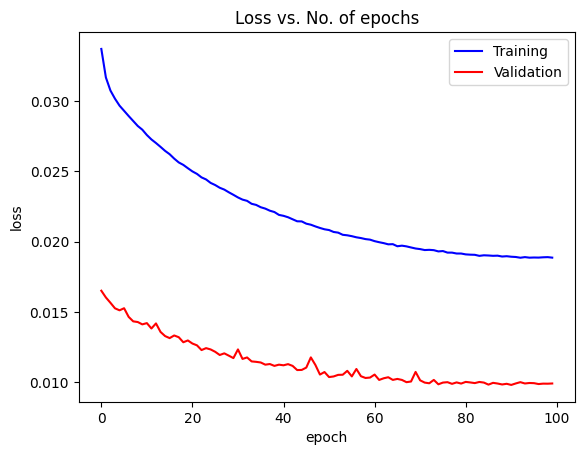

In [26]:
plot_loss(history4['train_loss'], history4['val_loss'])

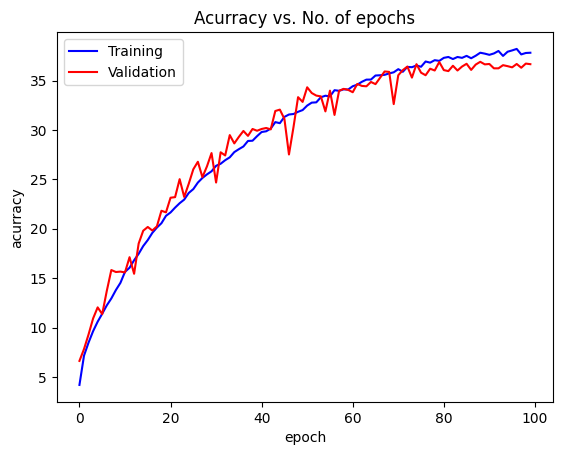

In [27]:
plot_acc(history4['train_acc'], history4['val_acc'])

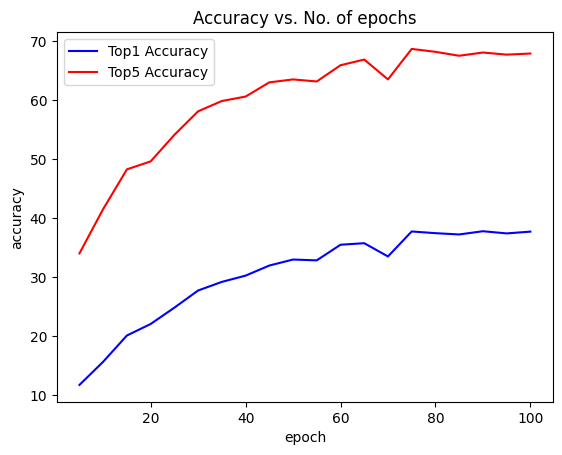

In [28]:
plot_test(history4['test_acc1'], history4['test_acc5'])

In [29]:
time_taken4 = np.array(history4['time'])
print("Average time per epoch for Wide_LAAResNet =", np.mean(time_taken4))

Average time per epoch for Wide_LAAResNet = 2.426478066444397


In [30]:
with open('simple_cnn_history', 'wb') as f:
  pickle.dump(history4, f)

In [31]:
class Simple_AACNN(nn.Module):
    def __init__(self, dropout=0.33, num_classes=100):
        super().__init__()
        
        self.block0 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )

        self.block1 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            # nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1),
            AttentionConv2d(
                input_dim=32,
                output_dim=64,
                dk=32,
                dv=32,
                kernel_size=3,
                padding=1,
                device=device,
                height=16,
                width=16,
                num_heads=2,
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            # nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1),
            AttentionConv2d(
                input_dim=128,
                output_dim=256,
                dk=128,
                dv=128,
                kernel_size=3,
                padding=1,
                device=device,
                height=8,
                width=8,
                num_heads=4,
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        self.pool = nn.AvgPool2d(8, 8)

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        # x.shape = B x 3 X 32 x 32

        x = self.block0(x)
        # x.shape = B x 16 X 32 x 32

        x = self.block1(x)
        # x.shape = B x 64 X 16 x 16

        x = self.block2(x)
        # x.shape = B x 256 X 8 x 8

        x = self.pool(x)
        # x.shape = B x 256 X 1 x 1

        x = torch.flatten(x, start_dim=1)
        # x.shape = B x 256

        x = self.fc(x)
        # x.shape = B x num_classes

        return x

In [32]:
model5 = Simple_AACNN(dropout=0.5).to(device)
summary(model5, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
       BatchNorm2d-5           [-1, 32, 16, 16]              64
              ReLU-6           [-1, 32, 16, 16]               0
         Dropout2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 32, 16, 16]           9,248
            Conv2d-9           [-1, 96, 16, 16]           3,168
          Softmax-10          [-1, 2, 256, 256]               0
           Conv2d-11           [-1, 32, 16, 16]           1,056
  AttentionConv2d-12           [-1, 64, 16, 16]               0
      BatchNorm2d-13           [-1, 64, 16, 16]             128
             ReLU-14           [-1, 64,

In [33]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=256, shuffle=False)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False)

optimizer = torch.optim.SGD
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR
loss_fn = F.cross_entropy

history5 = train(model5, optimizer, scheduler, loss_fn, train_loader, validation_loader, test_loader, learning_rate=0.01, num_epochs=100)

  1%|          | 1/100 [00:04<07:08,  4.33s/it]

Epoch 1 -	Training Loss : 0.033680292023552785 	Validation Loss : 0.01633855586051941


  2%|▏         | 2/100 [00:08<06:57,  4.26s/it]

Epoch 2 -	Training Loss : 0.03148454679383172 	Validation Loss : 0.015572193813323974


  3%|▎         | 3/100 [00:12<06:45,  4.18s/it]

Epoch 3 -	Training Loss : 0.03040196294784546 	Validation Loss : 0.01588162302970886


  4%|▍         | 4/100 [00:16<06:33,  4.10s/it]

Epoch 4 -	Training Loss : 0.029549262942208183 	Validation Loss : 0.014664872312545776
Epoch 5 -	Training Loss : 0.028680174191792807 	Validation Loss : 0.013994743394851685


  5%|▌         | 5/100 [00:21<06:49,  4.31s/it]

Training Accuracy = 12.606666666666667 	Validation Accuracy = 15.18 	Test Accuracy Top1 = 16.46 	Test Accuracy Top5 = 42.34


  6%|▌         | 6/100 [00:25<06:40,  4.26s/it]

Epoch 6 -	Training Loss : 0.027934277163611517 	Validation Loss : 0.013951021957397461


  7%|▋         | 7/100 [00:29<06:38,  4.29s/it]

Epoch 7 -	Training Loss : 0.027293158451716103 	Validation Loss : 0.013653543758392334


  8%|▊         | 8/100 [00:33<06:26,  4.20s/it]

Epoch 8 -	Training Loss : 0.026651970630221896 	Validation Loss : 0.013131082725524903


  9%|▉         | 9/100 [00:37<06:13,  4.11s/it]

Epoch 9 -	Training Loss : 0.026066623809602524 	Validation Loss : 0.012687776756286621
Epoch 10 -	Training Loss : 0.025532343520058527 	Validation Loss : 0.013143512964248658


 10%|█         | 10/100 [00:41<06:14,  4.16s/it]

Training Accuracy = 20.153333333333332 	Validation Accuracy = 20.3 	Test Accuracy Top1 = 21.26 	Test Accuracy Top5 = 48.88


 11%|█         | 11/100 [00:45<06:02,  4.08s/it]

Epoch 11 -	Training Loss : 0.025102223205566408 	Validation Loss : 0.013327387523651124


 12%|█▏        | 12/100 [00:50<06:08,  4.19s/it]

Epoch 12 -	Training Loss : 0.0246488249513838 	Validation Loss : 0.012237443256378175


 13%|█▎        | 13/100 [00:54<06:00,  4.15s/it]

Epoch 13 -	Training Loss : 0.024240676630867854 	Validation Loss : 0.011884193134307861


 14%|█▍        | 14/100 [00:58<06:01,  4.21s/it]

Epoch 14 -	Training Loss : 0.02384349415567186 	Validation Loss : 0.011726079416275025
Epoch 15 -	Training Loss : 0.023506303294499716 	Validation Loss : 0.011483394145965576


 15%|█▌        | 15/100 [01:03<05:59,  4.23s/it]

Training Accuracy = 25.204444444444444 	Validation Accuracy = 27.66 	Test Accuracy Top1 = 28.04 	Test Accuracy Top5 = 58.55


 16%|█▌        | 16/100 [01:07<05:54,  4.22s/it]

Epoch 16 -	Training Loss : 0.023250437286165025 	Validation Loss : 0.011384722328186036


 17%|█▋        | 17/100 [01:11<05:45,  4.16s/it]

Epoch 17 -	Training Loss : 0.022844626092910766 	Validation Loss : 0.011392267036437989


 18%|█▊        | 18/100 [01:15<05:40,  4.15s/it]

Epoch 18 -	Training Loss : 0.022551563861634996 	Validation Loss : 0.011141513252258302


 19%|█▉        | 19/100 [01:19<05:31,  4.10s/it]

Epoch 19 -	Training Loss : 0.02227285704082913 	Validation Loss : 0.011366171979904175
Epoch 20 -	Training Loss : 0.022017424472173055 	Validation Loss : 0.011434448671340943


 20%|██        | 20/100 [01:23<05:30,  4.13s/it]

Training Accuracy = 28.824444444444445 	Validation Accuracy = 28.18 	Test Accuracy Top1 = 28.81 	Test Accuracy Top5 = 58.84


 21%|██        | 21/100 [01:27<05:27,  4.14s/it]

Epoch 21 -	Training Loss : 0.021821156220965917 	Validation Loss : 0.011273054599761963


 22%|██▏       | 22/100 [01:31<05:19,  4.09s/it]

Epoch 22 -	Training Loss : 0.021561101145214506 	Validation Loss : 0.010794683074951171


 23%|██▎       | 23/100 [01:35<05:12,  4.06s/it]

Epoch 23 -	Training Loss : 0.021415315055847168 	Validation Loss : 0.01052014079093933


 24%|██▍       | 24/100 [01:40<05:20,  4.22s/it]

Epoch 24 -	Training Loss : 0.0211833670563168 	Validation Loss : 0.010806687927246093
Epoch 25 -	Training Loss : 0.02100102252430386 	Validation Loss : 0.010899731492996216


 25%|██▌       | 25/100 [01:45<05:36,  4.48s/it]

Training Accuracy = 31.695555555555554 	Validation Accuracy = 31.46 	Test Accuracy Top1 = 31.48 	Test Accuracy Top5 = 62.11


 26%|██▌       | 26/100 [01:50<05:39,  4.59s/it]

Epoch 26 -	Training Loss : 0.02083232519891527 	Validation Loss : 0.010193975162506103


 27%|██▋       | 27/100 [01:54<05:38,  4.63s/it]

Epoch 27 -	Training Loss : 0.020651866266462537 	Validation Loss : 0.010674537134170532


 28%|██▊       | 28/100 [01:59<05:24,  4.51s/it]

Epoch 28 -	Training Loss : 0.020523852284749348 	Validation Loss : 0.010638572454452514


 29%|██▉       | 29/100 [02:03<05:15,  4.45s/it]

Epoch 29 -	Training Loss : 0.02037420958942837 	Validation Loss : 0.01003291482925415
Epoch 30 -	Training Loss : 0.020220590808656482 	Validation Loss : 0.010313761472702026


 30%|███       | 30/100 [02:08<05:14,  4.49s/it]

Training Accuracy = 33.782222222222224 	Validation Accuracy = 34.2 	Test Accuracy Top1 = 34.33 	Test Accuracy Top5 = 65.62


 31%|███       | 31/100 [02:12<05:02,  4.39s/it]

Epoch 31 -	Training Loss : 0.020005118216408622 	Validation Loss : 0.010378595209121703


 32%|███▏      | 32/100 [02:16<04:55,  4.35s/it]

Epoch 32 -	Training Loss : 0.01994690498775906 	Validation Loss : 0.010370178508758545


 33%|███▎      | 33/100 [02:20<04:51,  4.35s/it]

Epoch 33 -	Training Loss : 0.019760579268137613 	Validation Loss : 0.010257878494262695


 34%|███▍      | 34/100 [02:25<04:44,  4.31s/it]

Epoch 34 -	Training Loss : 0.01969682316250271 	Validation Loss : 0.010211483764648437
Epoch 35 -	Training Loss : 0.019533918274773493 	Validation Loss : 0.010323181343078613


 35%|███▌      | 35/100 [02:29<04:46,  4.40s/it]

Training Accuracy = 35.422222222222224 	Validation Accuracy = 34.44 	Test Accuracy Top1 = 34.48 	Test Accuracy Top5 = 65.52


 36%|███▌      | 36/100 [02:33<04:37,  4.33s/it]

Epoch 36 -	Training Loss : 0.019440221314960055 	Validation Loss : 0.010235028171539307


 37%|███▋      | 37/100 [02:37<04:29,  4.28s/it]

Epoch 37 -	Training Loss : 0.019349821604622734 	Validation Loss : 0.0102431321144104


 38%|███▊      | 38/100 [02:42<04:24,  4.26s/it]

Epoch 38 -	Training Loss : 0.019171468138694765 	Validation Loss : 0.010056444931030273


 39%|███▉      | 39/100 [02:46<04:22,  4.30s/it]

Epoch 39 -	Training Loss : 0.01906923729578654 	Validation Loss : 0.009919721603393555
Epoch 40 -	Training Loss : 0.018960141775343154 	Validation Loss : 0.009970775842666625


 40%|████      | 40/100 [02:51<04:23,  4.40s/it]

Training Accuracy = 36.92666666666667 	Validation Accuracy = 36.08 	Test Accuracy Top1 = 36.48 	Test Accuracy Top5 = 66.92


 41%|████      | 41/100 [02:55<04:16,  4.34s/it]

Epoch 41 -	Training Loss : 0.018907534874810113 	Validation Loss : 0.009828093051910401


 42%|████▏     | 42/100 [02:59<04:10,  4.31s/it]

Epoch 42 -	Training Loss : 0.018788868808746337 	Validation Loss : 0.009688775539398193


 43%|████▎     | 43/100 [03:04<04:11,  4.41s/it]

Epoch 43 -	Training Loss : 0.018626252428690593 	Validation Loss : 0.009765409469604492


 44%|████▍     | 44/100 [03:08<04:06,  4.40s/it]

Epoch 44 -	Training Loss : 0.018601632115576004 	Validation Loss : 0.009691337633132934
Epoch 45 -	Training Loss : 0.018463169609175788 	Validation Loss : 0.009749875068664551


 45%|████▌     | 45/100 [03:13<04:06,  4.49s/it]

Training Accuracy = 38.49777777777778 	Validation Accuracy = 37.4 	Test Accuracy Top1 = 36.97 	Test Accuracy Top5 = 67.89


 46%|████▌     | 46/100 [03:17<03:57,  4.39s/it]

Epoch 46 -	Training Loss : 0.018430547065205045 	Validation Loss : 0.009894072532653808


 47%|████▋     | 47/100 [03:21<03:49,  4.32s/it]

Epoch 47 -	Training Loss : 0.018293217092090183 	Validation Loss : 0.00984237117767334


 48%|████▊     | 48/100 [03:25<03:41,  4.26s/it]

Epoch 48 -	Training Loss : 0.0182425434589386 	Validation Loss : 0.009921484804153443


 49%|████▉     | 49/100 [03:29<03:32,  4.16s/it]

Epoch 49 -	Training Loss : 0.018142985118760002 	Validation Loss : 0.009946685361862183
Epoch 50 -	Training Loss : 0.018055809762742785 	Validation Loss : 0.009501565170288086


 50%|█████     | 50/100 [03:34<03:30,  4.22s/it]

Training Accuracy = 39.54 	Validation Accuracy = 38.7 	Test Accuracy Top1 = 39.21 	Test Accuracy Top5 = 69.52


 51%|█████     | 51/100 [03:38<03:25,  4.19s/it]

Epoch 51 -	Training Loss : 0.018007435682084825 	Validation Loss : 0.009611367988586425


 52%|█████▏    | 52/100 [03:42<03:28,  4.35s/it]

Epoch 52 -	Training Loss : 0.017922364547517566 	Validation Loss : 0.00972190351486206


 53%|█████▎    | 53/100 [03:47<03:22,  4.30s/it]

Epoch 53 -	Training Loss : 0.017852112452189126 	Validation Loss : 0.009590909433364868


 54%|█████▍    | 54/100 [03:51<03:13,  4.22s/it]

Epoch 54 -	Training Loss : 0.01784197918838925 	Validation Loss : 0.009876457643508911
Epoch 55 -	Training Loss : 0.01770696229669783 	Validation Loss : 0.00980121955871582


 55%|█████▌    | 55/100 [03:55<03:14,  4.33s/it]

Training Accuracy = 40.39111111111111 	Validation Accuracy = 37.44 	Test Accuracy Top1 = 37.41 	Test Accuracy Top5 = 68.51


 56%|█████▌    | 56/100 [04:00<03:11,  4.35s/it]

Epoch 56 -	Training Loss : 0.017657736214001973 	Validation Loss : 0.009482958555221558


 57%|█████▋    | 57/100 [04:04<03:03,  4.26s/it]

Epoch 57 -	Training Loss : 0.017633680600590177 	Validation Loss : 0.009696120309829711


 58%|█████▊    | 58/100 [04:08<02:56,  4.21s/it]

Epoch 58 -	Training Loss : 0.017571288797590467 	Validation Loss : 0.009538482332229615


 59%|█████▉    | 59/100 [04:12<02:52,  4.20s/it]

Epoch 59 -	Training Loss : 0.017408717301156784 	Validation Loss : 0.009482285356521606
Epoch 60 -	Training Loss : 0.017373332866032917 	Validation Loss : 0.00944738211631775


 60%|██████    | 60/100 [04:17<02:54,  4.35s/it]

Training Accuracy = 41.34 	Validation Accuracy = 39.3 	Test Accuracy Top1 = 39.15 	Test Accuracy Top5 = 70.06


 61%|██████    | 61/100 [04:21<02:48,  4.31s/it]

Epoch 61 -	Training Loss : 0.01732019506825341 	Validation Loss : 0.009638325309753419


 62%|██████▏   | 62/100 [04:25<02:42,  4.27s/it]

Epoch 62 -	Training Loss : 0.017280956541167364 	Validation Loss : 0.009164255905151367


 63%|██████▎   | 63/100 [04:30<02:40,  4.33s/it]

Epoch 63 -	Training Loss : 0.017201846618122525 	Validation Loss : 0.009424402141571045


 64%|██████▍   | 64/100 [04:34<02:33,  4.27s/it]

Epoch 64 -	Training Loss : 0.01716788138548533 	Validation Loss : 0.009235774755477905
Epoch 65 -	Training Loss : 0.017092652996381123 	Validation Loss : 0.009116126871109008


 65%|██████▌   | 65/100 [04:38<02:34,  4.42s/it]

Training Accuracy = 42.36888888888889 	Validation Accuracy = 40.92 	Test Accuracy Top1 = 40.7 	Test Accuracy Top5 = 71.68


 66%|██████▌   | 66/100 [04:43<02:28,  4.38s/it]

Epoch 66 -	Training Loss : 0.017012703333960637 	Validation Loss : 0.009474368238449096


 67%|██████▋   | 67/100 [04:47<02:22,  4.32s/it]

Epoch 67 -	Training Loss : 0.017002356953091092 	Validation Loss : 0.009137780952453614


 68%|██████▊   | 68/100 [04:51<02:16,  4.27s/it]

Epoch 68 -	Training Loss : 0.016969173823462594 	Validation Loss : 0.009400072336196899


 69%|██████▉   | 69/100 [04:55<02:12,  4.27s/it]

Epoch 69 -	Training Loss : 0.016916664351357354 	Validation Loss : 0.009336903619766235
Epoch 70 -	Training Loss : 0.01685750390423669 	Validation Loss : 0.009121790742874145


 70%|███████   | 70/100 [05:00<02:08,  4.30s/it]

Training Accuracy = 42.55777777777778 	Validation Accuracy = 41.42 	Test Accuracy Top1 = 41.02 	Test Accuracy Top5 = 71.36


 71%|███████   | 71/100 [05:04<02:02,  4.22s/it]

Epoch 71 -	Training Loss : 0.016831515571806167 	Validation Loss : 0.009319070291519165


 72%|███████▏  | 72/100 [05:08<01:56,  4.16s/it]

Epoch 72 -	Training Loss : 0.01678932230207655 	Validation Loss : 0.009101046895980834


 73%|███████▎  | 73/100 [05:12<01:50,  4.09s/it]

Epoch 73 -	Training Loss : 0.016733943955103556 	Validation Loss : 0.009163379430770875


 74%|███████▍  | 74/100 [05:16<01:48,  4.19s/it]

Epoch 74 -	Training Loss : 0.016715664717886183 	Validation Loss : 0.009203244018554688
Epoch 75 -	Training Loss : 0.016650393856896293 	Validation Loss : 0.009284759330749511


 75%|███████▌  | 75/100 [05:21<01:49,  4.38s/it]

Training Accuracy = 43.68 	Validation Accuracy = 40.06 	Test Accuracy Top1 = 40.53 	Test Accuracy Top5 = 70.73


 76%|███████▌  | 76/100 [05:25<01:44,  4.37s/it]

Epoch 76 -	Training Loss : 0.01661049148241679 	Validation Loss : 0.009206486654281617


 77%|███████▋  | 77/100 [05:29<01:37,  4.25s/it]

Epoch 77 -	Training Loss : 0.016599120659298368 	Validation Loss : 0.009144189405441283


 78%|███████▊  | 78/100 [05:33<01:31,  4.16s/it]

Epoch 78 -	Training Loss : 0.01655045001241896 	Validation Loss : 0.009097465372085571


 79%|███████▉  | 79/100 [05:38<01:28,  4.24s/it]

Epoch 79 -	Training Loss : 0.016466707521014742 	Validation Loss : 0.009170820951461793
Epoch 80 -	Training Loss : 0.016485730338096617 	Validation Loss : 0.009205805683135986


 80%|████████  | 80/100 [05:42<01:27,  4.37s/it]

Training Accuracy = 43.86888888888889 	Validation Accuracy = 40.82 	Test Accuracy Top1 = 40.74 	Test Accuracy Top5 = 71.05


 81%|████████  | 81/100 [05:46<01:21,  4.31s/it]

Epoch 81 -	Training Loss : 0.016444378402498034 	Validation Loss : 0.00916848201751709


 82%|████████▏ | 82/100 [05:50<01:15,  4.21s/it]

Epoch 82 -	Training Loss : 0.01637997917334239 	Validation Loss : 0.009133082246780395


 83%|████████▎ | 83/100 [05:55<01:11,  4.19s/it]

Epoch 83 -	Training Loss : 0.016416834942499795 	Validation Loss : 0.009077168083190918


 84%|████████▍ | 84/100 [05:59<01:06,  4.15s/it]

Epoch 84 -	Training Loss : 0.016443930260340373 	Validation Loss : 0.009177475357055664
Epoch 85 -	Training Loss : 0.016393311728371513 	Validation Loss : 0.009133729791641235


 85%|████████▌ | 85/100 [06:03<01:03,  4.21s/it]

Training Accuracy = 44.36 	Validation Accuracy = 41.24 	Test Accuracy Top1 = 41.19 	Test Accuracy Top5 = 71.46


 86%|████████▌ | 86/100 [06:07<00:59,  4.24s/it]

Epoch 86 -	Training Loss : 0.016385558523072136 	Validation Loss : 0.009152663135528564


 87%|████████▋ | 87/100 [06:12<00:55,  4.24s/it]

Epoch 87 -	Training Loss : 0.0163676242351532 	Validation Loss : 0.009043241119384766


 88%|████████▊ | 88/100 [06:16<00:51,  4.33s/it]

Epoch 88 -	Training Loss : 0.0163057209332784 	Validation Loss : 0.009049474668502807


 89%|████████▉ | 89/100 [06:21<00:48,  4.43s/it]

Epoch 89 -	Training Loss : 0.016342870185110304 	Validation Loss : 0.009116717290878295
Epoch 90 -	Training Loss : 0.01631719114250607 	Validation Loss : 0.009042673778533936


 90%|█████████ | 90/100 [06:25<00:45,  4.51s/it]

Training Accuracy = 44.44222222222222 	Validation Accuracy = 41.66 	Test Accuracy Top1 = 41.74 	Test Accuracy Top5 = 71.94


 91%|█████████ | 91/100 [06:30<00:39,  4.41s/it]

Epoch 91 -	Training Loss : 0.016259963856803047 	Validation Loss : 0.009123216247558593


 92%|█████████▏| 92/100 [06:34<00:35,  4.39s/it]

Epoch 92 -	Training Loss : 0.016260779211256238 	Validation Loss : 0.009105785369873047


 93%|█████████▎| 93/100 [06:38<00:29,  4.27s/it]

Epoch 93 -	Training Loss : 0.016236750655704076 	Validation Loss : 0.00905595841407776


 94%|█████████▍| 94/100 [06:42<00:25,  4.29s/it]

Epoch 94 -	Training Loss : 0.0162286733256446 	Validation Loss : 0.00913818941116333
Epoch 95 -	Training Loss : 0.016274516497717963 	Validation Loss : 0.009028203010559082


 95%|█████████▌| 95/100 [06:47<00:22,  4.43s/it]

Training Accuracy = 44.5 	Validation Accuracy = 41.56 	Test Accuracy Top1 = 41.6 	Test Accuracy Top5 = 71.95


 96%|█████████▌| 96/100 [06:52<00:17,  4.46s/it]

Epoch 96 -	Training Loss : 0.016238010136286417 	Validation Loss : 0.009017257976531983


 97%|█████████▋| 97/100 [06:56<00:13,  4.49s/it]

Epoch 97 -	Training Loss : 0.01622513030105167 	Validation Loss : 0.009180984115600586


 98%|█████████▊| 98/100 [07:00<00:08,  4.44s/it]

Epoch 98 -	Training Loss : 0.016235893734296163 	Validation Loss : 0.009074082088470459


 99%|█████████▉| 99/100 [07:05<00:04,  4.41s/it]

Epoch 99 -	Training Loss : 0.016209508066707186 	Validation Loss : 0.0090604811668396
Epoch 100 -	Training Loss : 0.016230485489633347 	Validation Loss : 0.009111312961578369


100%|██████████| 100/100 [07:10<00:00,  4.30s/it]

Training Accuracy = 44.82222222222222 	Validation Accuracy = 41.06 	Test Accuracy Top1 = 41.19 	Test Accuracy Top5 = 71.51


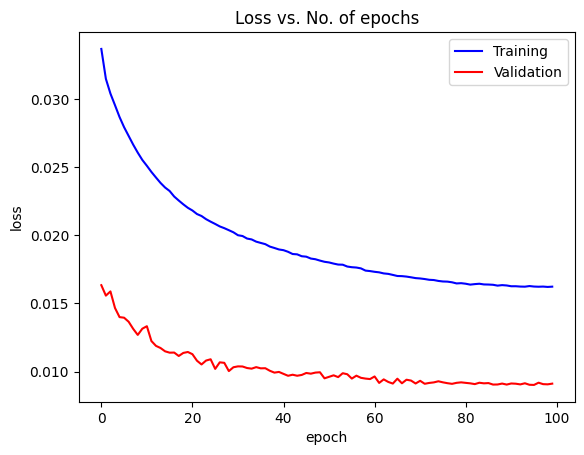

In [34]:
plot_loss(history5['train_loss'], history5['val_loss'])

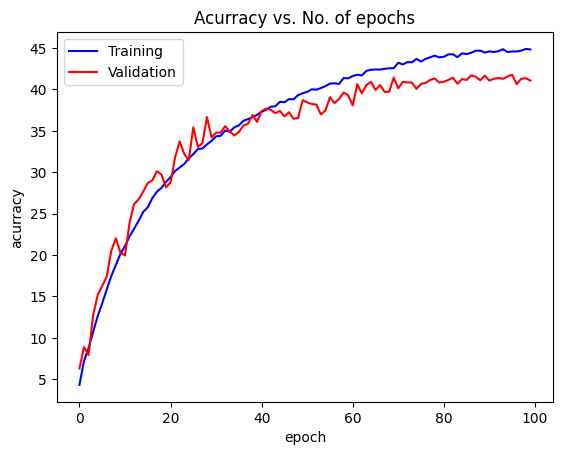

In [35]:
plot_acc(history5['train_acc'], history5['val_acc'])

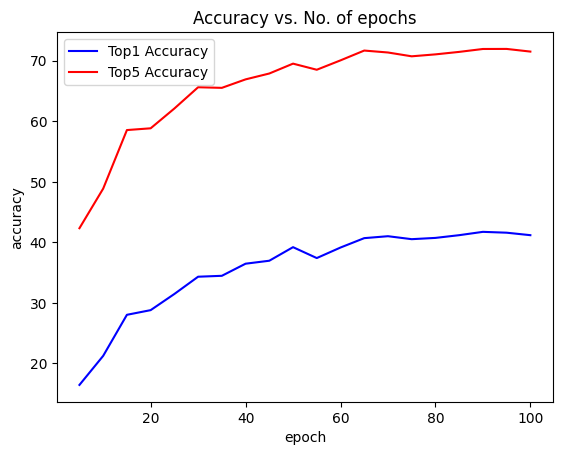

In [36]:
plot_test(history5['test_acc1'], history5['test_acc5'])

In [37]:
time_taken5 = np.array(history5['time'])
print("Average time per epoch for Wide_LAAResNet =", np.mean(time_taken5))

Average time per epoch for Wide_LAAResNet = 4.065692675113678


In [38]:
with open('simple_aacnn_history', 'wb') as f:
  pickle.dump(history5, f)

In [39]:
class Simple_LAACNN(nn.Module):
    def __init__(self, dropout=0.33, num_classes=100):
        super().__init__()
        
        self.block0 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1, stride=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
        )

        self.block1 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            # nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1),
            LinearAttentionConv2d(
                input_dim=32,
                output_dim=64,
                dk=32,
                dv=32,
                kernel_size=3,
                padding=1,
                device=device,
                height=16,
                width=16,
                num_heads=2,
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(),
        )

        self.block2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(dropout),
            # nn.Conv2d(128, 256, kernel_size=3, padding=1, stride=1),
            LinearAttentionConv2d(
                input_dim=128,
                output_dim=256,
                dk=128,
                dv=128,
                kernel_size=3,
                padding=1,
                device=device,
                height=8,
                width=8,
                num_heads=4,
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )

        self.pool = nn.AvgPool2d(8, 8)

        self.fc = nn.Linear(256, num_classes)

    def forward(self, x):
        # x.shape = B x 3 X 32 x 32

        x = self.block0(x)
        # x.shape = B x 16 X 32 x 32

        x = self.block1(x)
        # x.shape = B x 64 X 16 x 16

        x = self.block2(x)
        # x.shape = B x 256 X 8 x 8

        x = self.pool(x)
        # x.shape = B x 256 X 1 x 1

        x = torch.flatten(x, start_dim=1)
        # x.shape = B x 256

        x = self.fc(x)
        # x.shape = B x num_classes

        return x

In [40]:
model6 = Simple_LAACNN(dropout=0.5).to(device)
summary(model6, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             448
       BatchNorm2d-2           [-1, 16, 32, 32]              32
              ReLU-3           [-1, 16, 32, 32]               0
            Conv2d-4           [-1, 32, 16, 16]           4,640
       BatchNorm2d-5           [-1, 32, 16, 16]              64
              ReLU-6           [-1, 32, 16, 16]               0
         Dropout2d-7           [-1, 32, 16, 16]               0
            Conv2d-8           [-1, 32, 16, 16]           9,248
            Conv2d-9           [-1, 96, 16, 16]           3,168
          Softmax-10           [-1, 2, 16, 256]               0
          Softmax-11           [-1, 2, 16, 256]               0
           Conv2d-12           [-1, 32, 16, 16]           1,056
LinearAttentionConv2d-13           [-1, 64, 16, 16]               0
      BatchNorm2d-14           [-1,

In [41]:
train_loader = DataLoader(train_set, batch_size=128, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=256, shuffle=False)
test_loader = DataLoader(test_set, batch_size=256, shuffle=False)

optimizer = torch.optim.SGD
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR
loss_fn = F.cross_entropy

history6 = train(model6, optimizer, scheduler, loss_fn, train_loader, validation_loader, test_loader, learning_rate=0.01, num_epochs=100)

  1%|          | 1/100 [00:04<06:38,  4.02s/it]

Epoch 1 -	Training Loss : 0.033739100874794856 	Validation Loss : 0.01630452013015747


  2%|▏         | 2/100 [00:07<06:27,  3.95s/it]

Epoch 2 -	Training Loss : 0.031958035246531166 	Validation Loss : 0.016309043216705323


  3%|▎         | 3/100 [00:11<06:16,  3.88s/it]

Epoch 3 -	Training Loss : 0.031052877595689563 	Validation Loss : 0.01557305474281311


  4%|▍         | 4/100 [00:15<06:12,  3.88s/it]

Epoch 4 -	Training Loss : 0.030545580641428628 	Validation Loss : 0.015192869138717651
Epoch 5 -	Training Loss : 0.030119723632600574 	Validation Loss : 0.015068318557739258


  5%|▌         | 5/100 [00:19<06:23,  4.04s/it]

Training Accuracy = 9.437777777777777 	Validation Accuracy = 11.36 	Test Accuracy Top1 = 11.5 	Test Accuracy Top5 = 33.09


  6%|▌         | 6/100 [00:23<06:12,  3.96s/it]

Epoch 6 -	Training Loss : 0.02973611724641588 	Validation Loss : 0.015047743511199951


  7%|▋         | 7/100 [00:27<06:04,  3.92s/it]

Epoch 7 -	Training Loss : 0.029379590781529744 	Validation Loss : 0.01466857123374939


  8%|▊         | 8/100 [00:31<05:52,  3.83s/it]

Epoch 8 -	Training Loss : 0.02904984022246467 	Validation Loss : 0.01449723048210144


  9%|▉         | 9/100 [00:35<05:52,  3.87s/it]

Epoch 9 -	Training Loss : 0.028684899785783556 	Validation Loss : 0.014243205404281617
Epoch 10 -	Training Loss : 0.028386255428526137 	Validation Loss : 0.014170738124847412


 10%|█         | 10/100 [00:39<06:09,  4.11s/it]

Training Accuracy = 13.115555555555556 	Validation Accuracy = 15.78 	Test Accuracy Top1 = 15.7 	Test Accuracy Top5 = 41.01


 11%|█         | 11/100 [00:43<06:04,  4.09s/it]

Epoch 11 -	Training Loss : 0.028056029446919758 	Validation Loss : 0.013863201427459717


 12%|█▏        | 12/100 [00:47<05:52,  4.00s/it]

Epoch 12 -	Training Loss : 0.027783092742496067 	Validation Loss : 0.013753230714797974


 13%|█▎        | 13/100 [00:51<05:38,  3.90s/it]

Epoch 13 -	Training Loss : 0.027530609628889296 	Validation Loss : 0.01371747636795044


 14%|█▍        | 14/100 [00:55<05:42,  3.98s/it]

Epoch 14 -	Training Loss : 0.02725313431951735 	Validation Loss : 0.013499058198928833
Epoch 15 -	Training Loss : 0.026974245442284477 	Validation Loss : 0.013153653335571289


 15%|█▌        | 15/100 [00:59<05:50,  4.12s/it]

Training Accuracy = 16.36 	Validation Accuracy = 19.96 	Test Accuracy Top1 = 19.89 	Test Accuracy Top5 = 48.0


 16%|█▌        | 16/100 [01:03<05:39,  4.05s/it]

Epoch 16 -	Training Loss : 0.026758080503675674 	Validation Loss : 0.013360885000228882


 17%|█▋        | 17/100 [01:07<05:28,  3.96s/it]

Epoch 17 -	Training Loss : 0.026487819862365723 	Validation Loss : 0.01305240330696106


 18%|█▊        | 18/100 [01:11<05:22,  3.93s/it]

Epoch 18 -	Training Loss : 0.026291367610295612 	Validation Loss : 0.012900757932662963


 19%|█▉        | 19/100 [01:15<05:24,  4.01s/it]

Epoch 19 -	Training Loss : 0.026035410568449234 	Validation Loss : 0.013314328908920288
Epoch 20 -	Training Loss : 0.025804735665851168 	Validation Loss : 0.012701083326339721


 20%|██        | 20/100 [01:19<05:20,  4.01s/it]

Training Accuracy = 19.444444444444443 	Validation Accuracy = 22.74 	Test Accuracy Top1 = 22.75 	Test Accuracy Top5 = 51.62


 21%|██        | 21/100 [01:23<05:08,  3.90s/it]

Epoch 21 -	Training Loss : 0.025571958674324883 	Validation Loss : 0.01258496356010437


 22%|██▏       | 22/100 [01:26<04:59,  3.84s/it]

Epoch 22 -	Training Loss : 0.025448911656273734 	Validation Loss : 0.012639357328414917


 23%|██▎       | 23/100 [01:30<04:55,  3.84s/it]

Epoch 23 -	Training Loss : 0.02521862504747179 	Validation Loss : 0.012358912897109985


 24%|██▍       | 24/100 [01:35<05:01,  3.97s/it]

Epoch 24 -	Training Loss : 0.025095955271191066 	Validation Loss : 0.013677313566207886
Epoch 25 -	Training Loss : 0.024885465494791665 	Validation Loss : 0.012547466659545899


 25%|██▌       | 25/100 [01:39<05:14,  4.19s/it]

Training Accuracy = 21.744444444444444 	Validation Accuracy = 22.92 	Test Accuracy Top1 = 23.0 	Test Accuracy Top5 = 52.16


 26%|██▌       | 26/100 [01:43<05:04,  4.11s/it]

Epoch 26 -	Training Loss : 0.024763333219952055 	Validation Loss : 0.012349179458618164


 27%|██▋       | 27/100 [01:47<04:57,  4.07s/it]

Epoch 27 -	Training Loss : 0.02459069930712382 	Validation Loss : 0.012032522487640382


 28%|██▊       | 28/100 [01:51<04:50,  4.03s/it]

Epoch 28 -	Training Loss : 0.024445840305752226 	Validation Loss : 0.012218473577499389


 29%|██▉       | 29/100 [01:55<04:42,  3.98s/it]

Epoch 29 -	Training Loss : 0.02424351144366794 	Validation Loss : 0.011985594606399537
Epoch 30 -	Training Loss : 0.024122018067042034 	Validation Loss : 0.011859754419326782


 30%|███       | 30/100 [01:59<04:43,  4.05s/it]

Training Accuracy = 23.66888888888889 	Validation Accuracy = 26.58 	Test Accuracy Top1 = 26.79 	Test Accuracy Top5 = 57.22


 31%|███       | 31/100 [02:03<04:34,  3.98s/it]

Epoch 31 -	Training Loss : 0.023964346117443507 	Validation Loss : 0.011825047254562378


 32%|███▏      | 32/100 [02:07<04:25,  3.91s/it]

Epoch 32 -	Training Loss : 0.02383769702911377 	Validation Loss : 0.012014125299453735


 33%|███▎      | 33/100 [02:11<04:23,  3.94s/it]

Epoch 33 -	Training Loss : 0.023699045276641847 	Validation Loss : 0.011799258899688721


 34%|███▍      | 34/100 [02:15<04:17,  3.91s/it]

Epoch 34 -	Training Loss : 0.023587854920493232 	Validation Loss : 0.011622567272186279
Epoch 35 -	Training Loss : 0.023345145585801867 	Validation Loss : 0.011666478872299194


 35%|███▌      | 35/100 [02:19<04:19,  4.00s/it]

Training Accuracy = 25.404444444444444 	Validation Accuracy = 27.28 	Test Accuracy Top1 = 27.9 	Test Accuracy Top5 = 57.51


 36%|███▌      | 36/100 [02:23<04:11,  3.94s/it]

Epoch 36 -	Training Loss : 0.02331259315808614 	Validation Loss : 0.011573072147369384


 37%|███▋      | 37/100 [02:27<04:07,  3.93s/it]

Epoch 37 -	Training Loss : 0.02319244218932258 	Validation Loss : 0.011794537115097046


 38%|███▊      | 38/100 [02:31<04:05,  3.97s/it]

Epoch 38 -	Training Loss : 0.023073594782087536 	Validation Loss : 0.011549659204483032


 39%|███▉      | 39/100 [02:35<04:02,  3.98s/it]

Epoch 39 -	Training Loss : 0.022955212206310697 	Validation Loss : 0.011335615396499634
Epoch 40 -	Training Loss : 0.0228285293314192 	Validation Loss : 0.01120458745956421


 40%|████      | 40/100 [02:39<04:01,  4.03s/it]

Training Accuracy = 26.86888888888889 	Validation Accuracy = 30.76 	Test Accuracy Top1 = 30.51 	Test Accuracy Top5 = 61.09


 41%|████      | 41/100 [02:43<03:58,  4.04s/it]

Epoch 41 -	Training Loss : 0.02272632441520691 	Validation Loss : 0.01123480305671692


 42%|████▏     | 42/100 [02:46<03:47,  3.92s/it]

Epoch 42 -	Training Loss : 0.02261732006072998 	Validation Loss : 0.011243526697158814


 43%|████▎     | 43/100 [02:50<03:44,  3.94s/it]

Epoch 43 -	Training Loss : 0.02253254951371087 	Validation Loss : 0.011284297418594361


 44%|████▍     | 44/100 [02:54<03:36,  3.86s/it]

Epoch 44 -	Training Loss : 0.022490026415718928 	Validation Loss : 0.011047410726547241
Epoch 45 -	Training Loss : 0.022291424994998508 	Validation Loss : 0.011093110132217407


 45%|████▌     | 45/100 [02:58<03:32,  3.87s/it]

Training Accuracy = 28.27777777777778 	Validation Accuracy = 31.36 	Test Accuracy Top1 = 30.65 	Test Accuracy Top5 = 61.52


 46%|████▌     | 46/100 [03:02<03:26,  3.82s/it]

Epoch 46 -	Training Loss : 0.022289061578114826 	Validation Loss : 0.011059656953811645


 47%|████▋     | 47/100 [03:05<03:18,  3.75s/it]

Epoch 47 -	Training Loss : 0.022156701527701484 	Validation Loss : 0.010777835845947265


 48%|████▊     | 48/100 [03:09<03:22,  3.89s/it]

Epoch 48 -	Training Loss : 0.022034292597240872 	Validation Loss : 0.010947446584701538


 49%|████▉     | 49/100 [03:14<03:22,  3.98s/it]

Epoch 49 -	Training Loss : 0.021943104606204564 	Validation Loss : 0.010820215368270873
Epoch 50 -	Training Loss : 0.02187834635840522 	Validation Loss : 0.010648429012298583


 50%|█████     | 50/100 [03:18<03:27,  4.15s/it]

Training Accuracy = 29.186666666666667 	Validation Accuracy = 33.1 	Test Accuracy Top1 = 33.48 	Test Accuracy Top5 = 64.12


 51%|█████     | 51/100 [03:22<03:20,  4.09s/it]

Epoch 51 -	Training Loss : 0.021757274548212687 	Validation Loss : 0.010947771120071411


 52%|█████▏    | 52/100 [03:27<03:23,  4.23s/it]

Epoch 52 -	Training Loss : 0.021690065468682185 	Validation Loss : 0.010814393854141235


 53%|█████▎    | 53/100 [03:31<03:15,  4.15s/it]

Epoch 53 -	Training Loss : 0.02160334416495429 	Validation Loss : 0.01075944595336914


 54%|█████▍    | 54/100 [03:35<03:10,  4.15s/it]

Epoch 54 -	Training Loss : 0.021507487853368125 	Validation Loss : 0.010686503505706787
Epoch 55 -	Training Loss : 0.021417279301749335 	Validation Loss : 0.01051210470199585


 55%|█████▌    | 55/100 [03:39<03:09,  4.22s/it]

Training Accuracy = 30.357777777777777 	Validation Accuracy = 33.78 	Test Accuracy Top1 = 34.06 	Test Accuracy Top5 = 64.73


 56%|█████▌    | 56/100 [03:43<03:00,  4.09s/it]

Epoch 56 -	Training Loss : 0.021336992661158245 	Validation Loss : 0.010596545600891114


 57%|█████▋    | 57/100 [03:48<03:01,  4.22s/it]

Epoch 57 -	Training Loss : 0.021345062997606065 	Validation Loss : 0.010789637088775634


 58%|█████▊    | 58/100 [03:51<02:52,  4.12s/it]

Epoch 58 -	Training Loss : 0.021242706606123183 	Validation Loss : 0.010686895084381103


 59%|█████▉    | 59/100 [03:56<02:52,  4.20s/it]

Epoch 59 -	Training Loss : 0.02121060519748264 	Validation Loss : 0.010611127853393555
Epoch 60 -	Training Loss : 0.02116299490398831 	Validation Loss : 0.010547412586212158


 60%|██████    | 60/100 [04:00<02:48,  4.21s/it]

Training Accuracy = 31.211111111111112 	Validation Accuracy = 34.24 	Test Accuracy Top1 = 34.17 	Test Accuracy Top5 = 64.16


 61%|██████    | 61/100 [04:04<02:44,  4.21s/it]

Epoch 61 -	Training Loss : 0.02104571419292026 	Validation Loss : 0.010589077425003052


 62%|██████▏   | 62/100 [04:08<02:38,  4.18s/it]

Epoch 62 -	Training Loss : 0.02100331170823839 	Validation Loss : 0.010311950826644897


 63%|██████▎   | 63/100 [04:13<02:37,  4.25s/it]

Epoch 63 -	Training Loss : 0.020917150508032906 	Validation Loss : 0.010415819692611695


 64%|██████▍   | 64/100 [04:18<02:39,  4.42s/it]

Epoch 64 -	Training Loss : 0.020878312836752996 	Validation Loss : 0.010673338890075684
Epoch 65 -	Training Loss : 0.020809752946429783 	Validation Loss : 0.010497270345687867


 65%|██████▌   | 65/100 [04:23<02:43,  4.68s/it]

Training Accuracy = 32.3 	Validation Accuracy = 33.02 	Test Accuracy Top1 = 33.64 	Test Accuracy Top5 = 64.5


 66%|██████▌   | 66/100 [04:28<02:40,  4.73s/it]

Epoch 66 -	Training Loss : 0.020791390816370645 	Validation Loss : 0.010151877880096435


 67%|██████▋   | 67/100 [04:33<02:38,  4.80s/it]

Epoch 67 -	Training Loss : 0.020792322418424818 	Validation Loss : 0.01029278769493103


 68%|██████▊   | 68/100 [04:37<02:28,  4.63s/it]

Epoch 68 -	Training Loss : 0.020615399742126464 	Validation Loss : 0.010174695014953614


 69%|██████▉   | 69/100 [04:41<02:16,  4.41s/it]

Epoch 69 -	Training Loss : 0.020619538911183673 	Validation Loss : 0.010185592317581177
Epoch 70 -	Training Loss : 0.02056486783557468 	Validation Loss : 0.01021970329284668


 70%|███████   | 70/100 [04:45<02:14,  4.49s/it]

Training Accuracy = 32.69111111111111 	Validation Accuracy = 35.34 	Test Accuracy Top1 = 35.26 	Test Accuracy Top5 = 66.41


 71%|███████   | 71/100 [04:49<02:04,  4.29s/it]

Epoch 71 -	Training Loss : 0.0205247362030877 	Validation Loss : 0.010388483381271362


 72%|███████▏  | 72/100 [04:53<01:55,  4.11s/it]

Epoch 72 -	Training Loss : 0.02050958555539449 	Validation Loss : 0.01016850233078003


 73%|███████▎  | 73/100 [04:57<01:50,  4.09s/it]

Epoch 73 -	Training Loss : 0.02040251677301195 	Validation Loss : 0.010238160753250122


 74%|███████▍  | 74/100 [05:01<01:45,  4.07s/it]

Epoch 74 -	Training Loss : 0.020420906178156534 	Validation Loss : 0.010336228370666504
Epoch 75 -	Training Loss : 0.02037365166346232 	Validation Loss : 0.010091500234603881


 75%|███████▌  | 75/100 [05:05<01:44,  4.18s/it]

Training Accuracy = 33.54888888888889 	Validation Accuracy = 35.96 	Test Accuracy Top1 = 36.11 	Test Accuracy Top5 = 67.31


 76%|███████▌  | 76/100 [05:09<01:37,  4.08s/it]

Epoch 76 -	Training Loss : 0.02034367871814304 	Validation Loss : 0.010075211095809937


 77%|███████▋  | 77/100 [05:13<01:33,  4.05s/it]

Epoch 77 -	Training Loss : 0.02029985072877672 	Validation Loss : 0.010121208572387696


 78%|███████▊  | 78/100 [05:17<01:28,  4.03s/it]

Epoch 78 -	Training Loss : 0.02027425266901652 	Validation Loss : 0.010156277704238891


 79%|███████▉  | 79/100 [05:22<01:26,  4.11s/it]

Epoch 79 -	Training Loss : 0.020228771845499673 	Validation Loss : 0.009969021320343018
Epoch 80 -	Training Loss : 0.020176582664913602 	Validation Loss : 0.010053922653198242


 80%|████████  | 80/100 [05:26<01:23,  4.16s/it]

Training Accuracy = 33.69555555555556 	Validation Accuracy = 35.94 	Test Accuracy Top1 = 36.47 	Test Accuracy Top5 = 67.0


 81%|████████  | 81/100 [05:30<01:19,  4.17s/it]

Epoch 81 -	Training Loss : 0.02016400516827901 	Validation Loss : 0.010084996938705444


 82%|████████▏ | 82/100 [05:34<01:15,  4.18s/it]

Epoch 82 -	Training Loss : 0.020131777911716036 	Validation Loss : 0.010008166408538818


 83%|████████▎ | 83/100 [05:38<01:10,  4.13s/it]

Epoch 83 -	Training Loss : 0.020148625289069282 	Validation Loss : 0.010082298374176025


 84%|████████▍ | 84/100 [05:43<01:06,  4.17s/it]

Epoch 84 -	Training Loss : 0.02013537728521559 	Validation Loss : 0.010020000314712525
Epoch 85 -	Training Loss : 0.020092722585466172 	Validation Loss : 0.009982188415527343


 85%|████████▌ | 85/100 [05:47<01:02,  4.15s/it]

Training Accuracy = 34.14222222222222 	Validation Accuracy = 36.44 	Test Accuracy Top1 = 36.7 	Test Accuracy Top5 = 67.9


 86%|████████▌ | 86/100 [05:50<00:56,  4.03s/it]

Epoch 86 -	Training Loss : 0.02012736904886034 	Validation Loss : 0.009999742698669434


 87%|████████▋ | 87/100 [05:54<00:50,  3.92s/it]

Epoch 87 -	Training Loss : 0.02007279692755805 	Validation Loss : 0.01001360845565796


 88%|████████▊ | 88/100 [05:58<00:48,  4.03s/it]

Epoch 88 -	Training Loss : 0.020088590070936416 	Validation Loss : 0.010004256057739257


 89%|████████▉ | 89/100 [06:03<00:44,  4.09s/it]

Epoch 89 -	Training Loss : 0.020061443085140653 	Validation Loss : 0.009969753789901734
Epoch 90 -	Training Loss : 0.02005334356625875 	Validation Loss : 0.010038799667358399


 90%|█████████ | 90/100 [06:07<00:42,  4.28s/it]

Training Accuracy = 34.21111111111111 	Validation Accuracy = 36.32 	Test Accuracy Top1 = 36.35 	Test Accuracy Top5 = 67.33


 91%|█████████ | 91/100 [06:11<00:38,  4.22s/it]

Epoch 91 -	Training Loss : 0.020031696928872002 	Validation Loss : 0.009966126537322997


 92%|█████████▏| 92/100 [06:16<00:33,  4.19s/it]

Epoch 92 -	Training Loss : 0.019981664986080592 	Validation Loss : 0.009939491701126098


 93%|█████████▎| 93/100 [06:19<00:28,  4.10s/it]

Epoch 93 -	Training Loss : 0.01999233152601454 	Validation Loss : 0.009952716207504273


 94%|█████████▍| 94/100 [06:23<00:24,  4.01s/it]

Epoch 94 -	Training Loss : 0.019984088113572863 	Validation Loss : 0.009936041498184204
Epoch 95 -	Training Loss : 0.01997794171439277 	Validation Loss : 0.010016137027740478


 95%|█████████▌| 95/100 [06:28<00:20,  4.12s/it]

Training Accuracy = 34.74888888888889 	Validation Accuracy = 36.22 	Test Accuracy Top1 = 36.73 	Test Accuracy Top5 = 67.54


 96%|█████████▌| 96/100 [06:32<00:16,  4.16s/it]

Epoch 96 -	Training Loss : 0.019965832964579263 	Validation Loss : 0.009940037393569946


 97%|█████████▋| 97/100 [06:36<00:12,  4.08s/it]

Epoch 97 -	Training Loss : 0.019926129918628268 	Validation Loss : 0.009933631753921509


 98%|█████████▊| 98/100 [06:40<00:08,  4.21s/it]

Epoch 98 -	Training Loss : 0.019962157742182414 	Validation Loss : 0.009947450590133668


 99%|█████████▉| 99/100 [06:45<00:04,  4.25s/it]

Epoch 99 -	Training Loss : 0.019992633226182725 	Validation Loss : 0.009929231071472169
Epoch 100 -	Training Loss : 0.019988629955715605 	Validation Loss : 0.009964192295074463


100%|██████████| 100/100 [06:49<00:00,  4.09s/it]

Training Accuracy = 34.437777777777775 	Validation Accuracy = 36.26 	Test Accuracy Top1 = 36.88 	Test Accuracy Top5 = 67.81


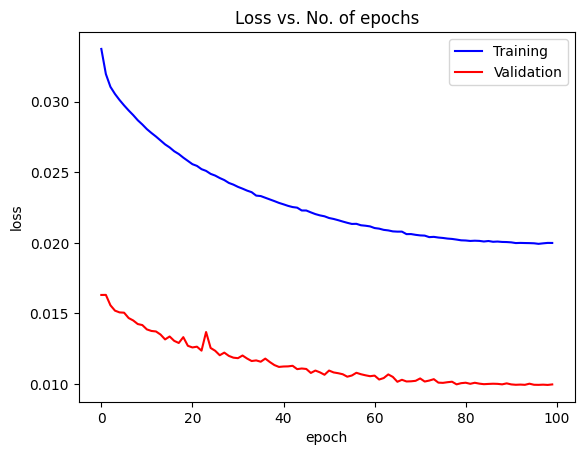

In [42]:
plot_loss(history6['train_loss'], history6['val_loss'])

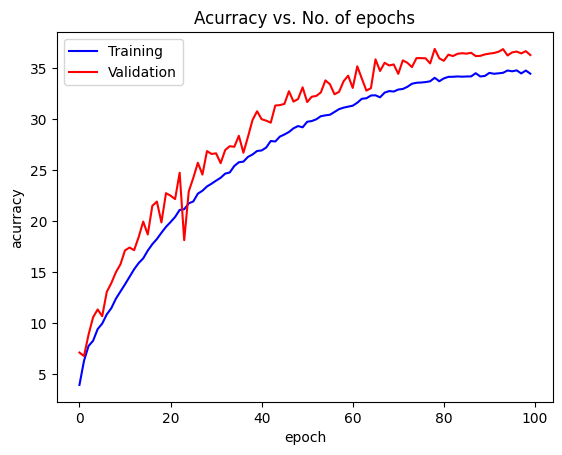

In [43]:
plot_acc(history6['train_acc'], history6['val_acc'])

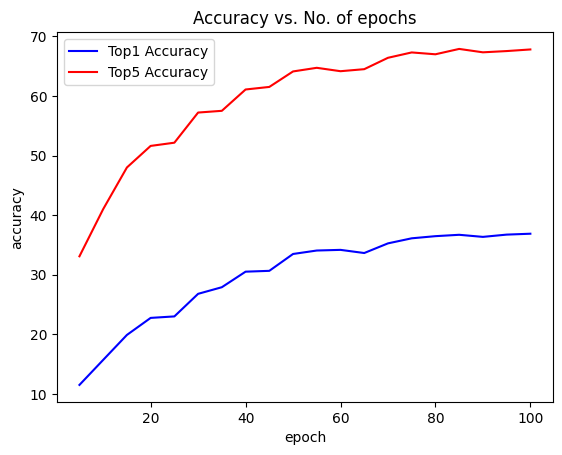

In [44]:
plot_test(history6['test_acc1'], history6['test_acc5'])

In [45]:
time_taken6 = np.array(history6['time'])
print("Average time per epoch for Wide_LAAResNet =", np.mean(time_taken6))

Average time per epoch for Wide_LAAResNet = 3.872080850601196


In [46]:
with open('simple_laacnn_history', 'wb') as f:
  pickle.dump(history6, f)